In [1]:
# Python Standard Library
import math
import importlib

# Third Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc, font_manager
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

# Personal Libraries
import data_processing as dp
importlib.reload(dp)

<module 'data_processing' from 'e:\\1C Cursos\\Data Science Part Time - The Bridge\\DS\\Proyecto\\data_processing.py'>

Load financial data in a single DataFrame sharing the same DateTime Index

In [2]:
importlib.reload(dp)
finance_path = 'data/finance.sqlite'
facts = dp.get_df_from(finance_path, 'Fact')

In [3]:
# Get tables that contain monthly values
monthly_data_series = list(facts[facts.Frequency == 'MENSUAL'].TableName.unique())
mothly_series = facts[facts.Frequency == 'MENSUAL'].SeriesAlias
dfs_dict = dp.get_df_from(finance_path, monthly_data_series)
dfs = [dp.set_datetime_axis(df, 'DateTime', '%Y-%m-%d') for key, df in dfs_dict.items()]
df = pd.concat(dfs, axis=1)
df = df['2000-01-01':]

# Even if the tables selected have monthly data,
# not all series inside these tables may be monthly, so I maintain only monthly data
df = df[mothly_series]

# Some series may not have data at all
# df.dropna(how='all', axis=0, inplace=True)
df.dropna(how='all', axis=1, inplace=True)
# Or the same data
df = df.loc[:, df.nunique() > 1]


# I may have non numeric data (dates), so I drop it now
non_float_columns = []
for col, values in df.iteritems():
    if not values.dtype == float:
        non_float_columns.append(col)
df.drop(columns=non_float_columns, inplace=True)

# df = df.astype('float')
print(df.shape)
df.head()

(276, 4027)


BE_19_1.1  BE_19_1.2  BE_19_1.3  BE_19_1.4  BE_19_1.5  BE_19_1.6  \
DateTime                                                                       
2000-01-01        NaN        NaN        NaN        NaN      3.949        NaN   
2000-02-01        NaN        NaN        NaN        NaN      4.111        NaN   
2000-03-01        NaN        NaN        NaN        NaN      4.267        NaN   
2000-04-01        NaN        NaN        NaN        NaN      4.365        NaN   
2000-05-01        NaN        NaN        NaN        NaN      4.849        NaN   

            BE_19_1.7  BE_19_1.8  BE_19_1.9  BE_19_1.10  ...  BE_25_9.2  \
DateTime                                                 ...              
2000-01-01        NaN        NaN        NaN         NaN  ...     103.15   
2000-02-01        NaN        NaN        NaN         NaN  ...     103.45   
2000-03-01        NaN        NaN        NaN         NaN  ...     103.47   
2000-04-01        NaN        NaN        NaN         NaN  ...     102.91   
2000-05-01        NaN        NaN        NaN         NaN  ...     103.92   

            BE_25_9.3  BE_25_9.4  BE_25_9.5  BE_25_9.6  BE_25_9.7  BE_25_9.8  \
DateTime                                                                       
2000-01-01     101.38     105.70     103.96     105.34      59.63      25.33   
2000-02-01     101.05     106.75     107.12     104.84      65.42      27.36   
2000-03-01     101.92     105.72     107.32     102.91      66.34      27.88   
2000-04-01     103.66     102.20     106.96      97.17      56.79      23.03   
2000-05-01     105.06     102.80     105.10      99.56      67.35      27.41   

            BE_25_9.9  BE_25_9.10  BE_25_9.11  
DateTime                                       
2000-01-01    101.916    284.3150        9.02  
2000-02-01    107.541    300.0071        9.82  
2000-03-01    102.660    286.3891        9.52  
2000-04-01    100.260    279.6944        9.50  
2000-05-01     98.649    275.2000        9.76  

[5 rows x 4027 columns]

In [4]:
# Get tables that contain daily or workday data
day_data_series = list(facts[(facts.Frequency == 'DIARIA') | (facts.Frequency == 'LABORABLE')].TableName.unique())
# len(day_data_series)

day_series = facts[(facts.Frequency == 'DIARIA') | (facts.Frequency == 'LABORABLE')].SeriesAlias

dfs_dict_day = dp.get_df_from(finance_path, day_data_series)
dfs_day = [dp.set_datetime_axis(df, 'DateTime', '%Y-%m-%d') for key, df in dfs_dict_day.items()]
df_day = pd.concat(dfs_day, axis=1)
df_day = df_day.groupby(pd.Grouper(freq='MS',convention='start')).mean()
df_day = df_day['2000-01-01':]
# Even if the tables selected have daily data,
# not all series inside these tables may be daily, so I maintain only daily data
df_day = df_day[day_series]

# Some series may not have data at all
# df_day.dropna(how='all', axis=0, inplace=True)
df_day.dropna(how='all', axis=1, inplace=True)
# Or the same data
df_day = df_day.loc[:, df_day.nunique() > 2]

print(df_day.shape)
df_day.head()

(274, 144)


TI_1_1.1  TI_1_1.2  TI_1_1.3  TI_1_1.4  TI_1_1.5  TI_1_1.7  \
DateTime                                                                 
2000-01-01     3.000     3.000     3.000      3.28       NaN       3.0   
2000-02-01     3.200     3.200     3.200       NaN       NaN       NaN   
2000-03-01     3.375     3.375     3.375      3.69       NaN       NaN   
2000-04-01     3.500     3.500     3.500      4.00       NaN       NaN   
2000-05-01     3.750     3.750     3.750      4.40       NaN       NaN   

            TI_1_1.9  TI_1_1.10  SI_2_2.1  SI_2_2.2  ...  TC_1_1.25  \
DateTime                                             ...              
2000-01-01  4.000000   2.000000     3.000    0.0000  ...  43.782538   
2000-02-01  4.214286   2.214286     3.200    0.0500  ...  42.890429   
2000-03-01  4.369565   2.369565     3.375    0.0625  ...  42.027391   
2000-04-01  4.513889   2.513889     3.500    0.0000  ...  41.325111   
2000-05-01  4.750000   2.750000     3.750    0.0500  ...  39.898136   

              TC_1_1.26  TC_1_1.27  TC_1_1.28  TC_1_1.29  TC_1_1.30  \
DateTime                                                              
2000-01-01  1145.872857   9.624271   3.853176   1.971629  41.031000   
2000-02-01  1110.757619   9.266333   3.737110   2.005695  39.961571   
2000-03-01  1076.116957   8.959974   3.663883   1.967435  39.493043   
2000-04-01  1051.415556   8.888778   3.598756   1.909672  39.022778   
2000-05-01  1015.270455   8.614655   3.442918   1.935514  37.950318   

            TC_1_1.31  TC_1_1.32  TC_1_1.33  SI_1_5.64  
DateTime                                                
2000-01-01   1.697343  37.861881   6.203133      5.798  
2000-02-01   1.673905  37.131538   6.213190      5.710  
2000-03-01   1.653835  36.545396   6.240809      5.446  
2000-04-01   1.619533  35.967761   6.279161        NaN  
2000-05-01   1.566518  35.297473   6.378259      5.505  

[5 rows x 144 columns]

In [5]:
# Merge data that is uploaded as monthly values and daily data grouped by month
df = pd.merge(df, df_day, left_index=True, right_index=True)
print(df.shape)
df.tail()

(274, 4171)


BE_19_1.1  BE_19_1.2  BE_19_1.3  BE_19_1.4  BE_19_1.5  BE_19_1.6  \
DateTime                                                                       
2022-06-01     -0.570     -0.525     -0.239      0.162      0.852     -0.579   
2022-07-01     -0.457     -0.306      0.037      0.466      0.992     -0.440   
2022-08-01     -0.071      0.022      0.395      0.837      1.249     -0.081   
2022-09-01      0.424      0.574      1.011      1.596      2.233      0.662   
2022-10-01        NaN        NaN        NaN        NaN        NaN        NaN   

            BE_19_1.7  BE_19_1.8  BE_19_1.9  BE_19_1.10  ...  TC_1_1.25  \
DateTime                                                 ...              
2022-06-01     -0.582     -0.583     -0.580      -0.574  ...  82.511209   
2022-07-01     -0.548     -0.572     -0.575      -0.573  ...  81.018248   
2022-08-01     -0.085     -0.393     -0.487      -0.529  ...  80.556287   
2022-09-01      0.300     -0.101     -0.342      -0.457  ...  79.455750   
2022-10-01        NaN        NaN        NaN         NaN  ...  80.858725   

              TC_1_1.26  TC_1_1.27  TC_1_1.28  TC_1_1.29  TC_1_1.30  \
DateTime                                                              
2022-06-01  1351.467727  21.123964   4.649645   1.664000  56.755909   
2022-07-01  1331.999524  20.895548   4.519748   1.643643  56.917238   
2022-08-01  1337.902609  20.390870   4.523343   1.615761  56.541957   
2022-09-01  1381.706818  19.871791   4.500518   1.669055  57.073500   
2022-10-01  1402.876000  19.644905   4.608930   1.730950  57.735400   

            TC_1_1.31  TC_1_1.32  TC_1_1.33  SI_1_5.64  
DateTime                                                
2022-06-01   1.462382  36.927727  16.696055      2.588  
2022-07-01   1.421114  37.028381  17.160624        NaN  
2022-08-01   1.401557  36.306348  16.918230      2.649  
2022-09-01   1.399850  36.669818  17.382773      3.369  
2022-10-01   1.400125  37.262700  17.803825        NaN  

[5 rows x 4171 columns]

Adjust for inflation

<AxesSubplot:xlabel='DateTime'>

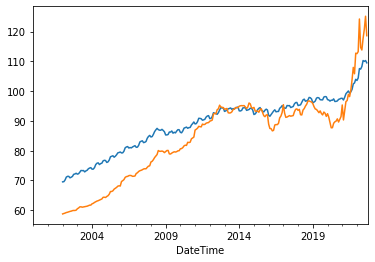

In [6]:
# Select CPI Series
df['BE_25_1.1'].plot()      # Índice General. Total Nacional. Índice
df['BE_25_1.5'].plot()      # Vivienda, agua, electricidad, gas y otros combustibles. Total Nacional. Índice

Load the rest of the data and adjust for inflation the quantities expressed in euros or derived from euros

In [7]:
def inflation_adjustment_series(cpi_series):
    """
    Given a CPI Series, get the last valid value and use it to return a series of adjustment factors,
    ready to be used as OLD_PRICE_SERIES * adjustment_series = ADJUSTED_PRICE

    Args:
        cpi_series : pd.Series with datetimeindex

    Returns:
        adjustment_series : pd.Series
    """
    new_CPI = cpi_series.dropna()[-1]
    adjustment_series = new_CPI/cpi_series
    return adjustment_series

inflation_adjustment = inflation_adjustment_series(df['BE_25_1.1'])       # Índice General. Total Nacional. Índice

# Which columns to adjust ?
financial_series = set(facts.loc[
    (facts.UnitDescription.str.contains('Euro', case=False).fillna(False)) &
    ~(facts.UnitDescription.str.contains('Base', case=False).fillna(False))].SeriesAlias)   # If it has Base then it's already adjusted

# Select only series that are in the df and contain economic data
financial_series = list(financial_series.intersection(set(df.columns)))

# Data adjusted for inflation
df[financial_series] = df[financial_series].multiply(inflation_adjustment, axis="index")

Create the gif frames to explain the time series correlation by offsetting the series

In [235]:
annotationstyle = {'size':20, 'fontname':'Constantia', 'va':'center'}
n_periods = 36
for offset in range(-n_periods,n_periods+1,1):
    feature = 'BE_24_20.18'

    target_series = df[target]
    feature_series = df[feature].shift(offset)

    # Plot df
    plot_df = pd.DataFrame({'target':df[target], 'feature':df[feature]})
    # Extend DataFrame
    if offset > 0:
        for i in range(offset):
            plot_df.loc[plot_df.index[-1] + pd.offsets.MonthBegin(i+1), 'feature'] = None
    plot_df['feature'] = plot_df['feature'].shift(offset)

    # Correlation
    corr_df = pd.DataFrame({'target':df[target], 'feature':df[feature]})
    corr_df['feature'] = corr_df['feature'].shift(offset)
    corr_df.dropna(inplace=True)
    corr_value = round(corr_df.corr()['target']['feature'], 7)

    start = target_series.dropna().index[0]
    # end = max(target_series.dropna().index[-1], feature_series.dropna().index[-1])

    feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    target_name = " ".join(facts[facts.SeriesAlias == target].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]

    # Plot data
    # fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
    fig, (ax, axsc) = plt.subplots(nrows=1, ncols=2, gridspec_kw=dict(width_ratios=[2,1]), figsize = (24,9), facecolor=dp.rgb(dp.BEIGE))

    ax2 = ax.twinx()
    p1, = ax.plot(plot_df.axes[0], plot_df['target'], color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{target}: Precio Fotocasa')
    p2, = ax2.plot(plot_df.axes[0], plot_df['feature'], color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {feature_full_name}. {feature_units}')

    ax.text(pd.to_datetime('2022-02-01'), 3200, 'Correlación', ha='right', color=dp.rgb(dp.CHARCOAL), **annotationstyle)
    ax.text(pd.to_datetime('2022-02-01'), 3100, 'Desfase', ha='right', color=dp.rgb(dp.CHARCOAL), **annotationstyle)

    ax.text(pd.to_datetime('2022-03-01'), 3200, corr_value, ha='left', **annotationstyle)
    ax.text(pd.to_datetime('2022-03-01'), 3100, f'{offset} meses', ha='left', **annotationstyle)

    ax.grid()
    ax.set_facecolor(dp.rgb(dp.BEIGE))
    ax.set_ylabel(facts[facts.SeriesAlias == target].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
    ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

    # Change tick styles
    ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
    ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
    ax2.tick_params('y', colors=dp.rgb(dp.RED))
    for x in [ax, ax2]:
        for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

    ax.set_xlim([start, pd.to_datetime('2026-01-01')])
    ax2.set_xlim([start, pd.to_datetime('2026-01-01')])
    plt.legend(handles=[p1,p2], loc='upper left' )


    # Plot scatter
    axsc.patch.set_facecolor(dp.rgb(dp.BEIGE))
    axsc.scatter(corr_df['target'], corr_df['feature'], color=dp.rgb(dp.CHARCOAL))
    axsc.set_ylim([440000, 500000])

    # plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name} con un desfase de {value["offset"]} meses')
    plt.tight_layout()
    plt.savefig(f'EDA/plot/time offset gif/{offset+n_periods+10}.png')
    # plt.show()
    plt.close()

Find correlated time series

In [8]:
def time_series_offset_correlation(correlation, df, target, feature, n_periods, min_correlation):
    """ Given a DataFrame and two series contained in it,
    calculates the correlation considering n offset period

    Args:
        correlation (_type_): _description_
        df (_type_): _description_
        target (_type_): _description_
        feature (_type_): _description_

    Returns:
        _type_: _description_
    """
    corrs = []
    for offset in range(-n_periods,n_periods+1,1):
        s = pd.DataFrame({0:df[target], 1:df[feature].shift(offset)})
        s.dropna(inplace=True)
        s = s.astype('float')
        if s[1].dropna().nunique() < 10:
            return
        statistic, pvalue = pearsonr(s[0], s[1])
        corrs.append((offset, statistic, pvalue))
        # Testing graphic
        # fig, ax = plt.subplots(figsize=(10,8))
        # ax2 = ax.twinx()
        # print(statistic, pvalue)
        # ax.plot(s[0], color='k')
        # # ax2.plot(s[0], color='b')
        # ax2.plot(s[1], color='r')
        # plt.show()
        # plt.close()

    max_correlation = max([statistic for offset, statistic, pvalue in corrs])
    for offset, statistic, pvalue in corrs:
        if (statistic == max_correlation) and (pvalue < .05) and ((statistic > min_correlation) or (statistic < -min_correlation)):
            # print(type(corrs), type(correlation))
            # print({'correlation':statistic, 'pvalue':pvalue, 'offset':offset})
            correlation[feature] = {'correlation':statistic, 'pvalue':pvalue, 'offset':offset}
            return

target = 'SI_1_5.11'    # Eur per square meter, Fotocasa
feature = 'BE_26_34.9'
correlation = {}

total = df.shape[1]
for i, feature in enumerate(df.columns):
    time_series_offset_correlation(correlation, df, target, feature, 36, min_correlation=.95)
    sys.stdout.write(f'\r{i}/{total}')
    sys.stdout.flush()
correlation.pop(target)

4170/4171

{'correlation': 1.0, 'pvalue': 0.0, 'offset': 0}

Let's see what the correlations have in common.

In [304]:
name = []
off = []
corr = []
units = []
freq = []

for key, value in correlation.items():
    name.append(key)
    corr.append(value['correlation'])
    off.append(value['offset'])
    units.append(facts.loc[facts.SeriesAlias == key, 'UnitDescription'].values[0])
    freq.append(facts.loc[facts.SeriesAlias == key, 'Frequency'].values[0])


dresult = pd.DataFrame({'name':name,'corr':corr, 'off':off, 'units':units, 'freq':freq})
# dresult.hist()
# plt.plot(x=dresult.o,y=dresult.c)

dresult['color'] = pd.factorize(dresult['units'])[0]


first_unique = len(dresult.color.unique())
print(len(dresult.color.unique()))
dresult.loc[dresult.units.str.contains('Euros'), 'color'] = first_unique + 1
dresult.loc[dresult.units.str.contains('Euros'), 'units'] = 'Euros'
dresult.loc[dresult.units.str.contains(' por '), 'color'] = first_unique + 2
dresult.loc[dresult.units.str.contains(' por '), 'units'] = 'Cambio con moneda extranjera'
dresult.loc[dresult.units.str.contains('Base'), 'color'] = first_unique + 3
dresult.loc[dresult.units.str.contains('Base'), 'units'] = 'Base constante'
print(len(dresult.color.unique()))

17
8


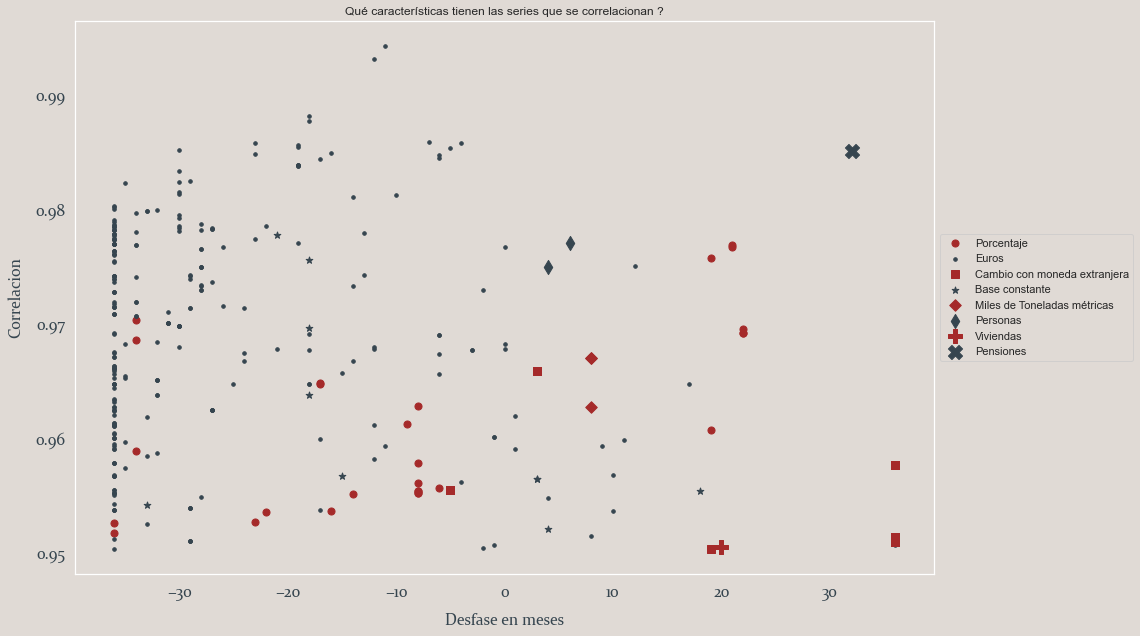

In [266]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(dresult.units.unique()), name='flag')
filled_markers = ('o', '.', 's', '*', 'D', 'd', 'P', 'X')
# '8', 's', 'p', '*',
# Plot
fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
ax.grid()
for i, color in enumerate(dresult.color.unique()):
    # ax.scatter(subdf['corr'], subdf['off'], color=cmap(i), marker=filled_markers[i], label=subdf.iloc[0]['units'], s= max(200/subdf.shape[0], 30))
    subdf = dresult[dresult.color == color]
    color = dp.rgb(dp.RED) if (i % 2) == 0 else dp.rgb(dp.CHARCOAL)
    ax.scatter(subdf['off'],subdf['corr'],color=color,marker=filled_markers[i],label=subdf.iloc[0]['units'],s=max(200/subdf.shape[0], 50))

ax.set_facecolor(dp.rgb(dp.BEIGE))
ax.set_xlabel('Desfase en meses', color=dp.rgb(dp.CHARCOAL), **labelstyle)
ax.set_ylabel('Correlacion', color=dp.rgb(dp.CHARCOAL), **labelstyle)

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))

for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

# plt.legend(labels = dresult['units'])
# plt.legend(handles=dresult['color'], loc='upper left' )

# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor=dp.rgb(dp.BEIGE))

plt.title(f'Qué características tienen las series que se correlacionan ?')
plt.tight_layout()
plt.savefig(f'EDA/plot/corr/Series con altas correlaciones.png')
plt.show()
plt.close()

Plot the obtained series

In [267]:
offset = 36

In [268]:
# Extend the base df because otherwise when I shift, I would lose the values after the last index value
dg = df.copy()
starting_index = dg.index[-1]
for i in range(offset):
    dg.loc[starting_index + pd.offsets.MonthBegin(i+1), target] = None

C:\Users\alex\AppData\Local\Temp/ipykernel_4768/4286053550.py:88: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024541BE3070> has a label of '_line0' which cannot be automatically added to the legend.
  plt.legend(handles=[p1,p2], loc='upper left' )


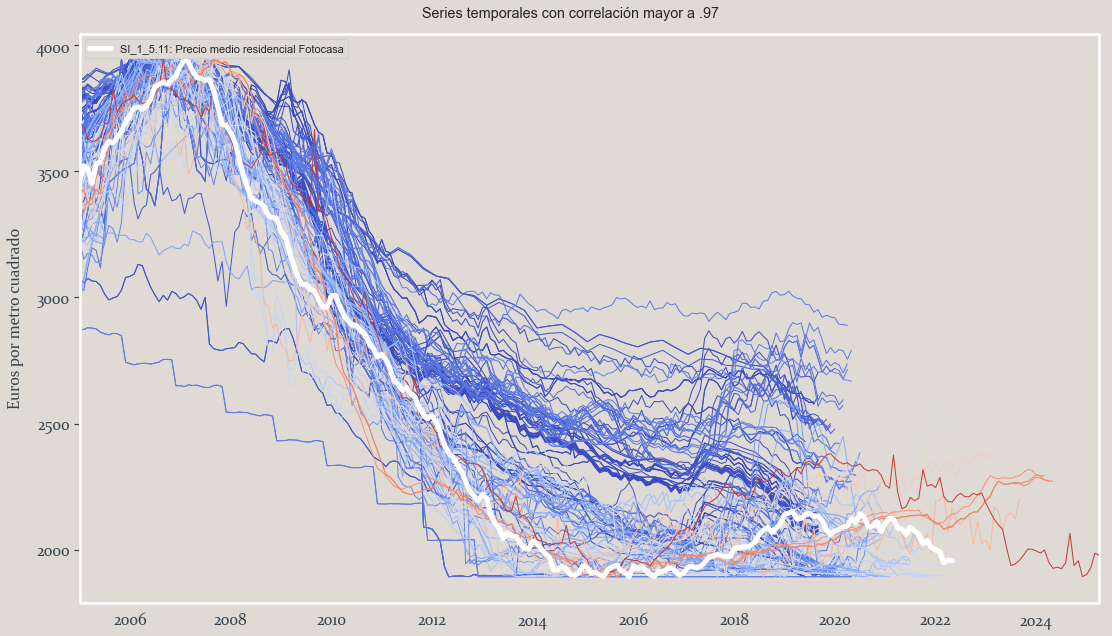

In [271]:
labelstyle = {'size':16, 'fontname':'Constantia','ha':'center', 'va':'center', 'labelpad':20}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}

def plot_pair_time_series(df, target, feature, value):
    target_series = df[target]
    feature_series = df[feature].shift(value['offset']).dropna()

    start = target_series.dropna().index[0]
    end = max(target_series.dropna().index[-1], feature_series.dropna().index[-1])

    feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    target_name = " ".join(facts[facts.SeriesAlias == target].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]

    # Plot data
    fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
    ax2 = ax.twinx()
    p1, = ax.plot(target_series.axes[0], target_series, color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{target}: Precio Fotocasa')
    p2, = ax2.plot(feature_series.axes[0], feature_series, color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {feature_full_name}. {feature_units}')

    ax.grid()
    ax.set_facecolor(dp.rgb(dp.BEIGE))
    ax.set_ylabel(facts[facts.SeriesAlias == target].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
    ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

    # Change tick styles
    ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
    ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
    ax2.tick_params('y', colors=dp.rgb(dp.RED))
    for x in [ax, ax2]:
        for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

    ax.set_xlim([start, end])
    plt.legend(handles=[p1,p2], loc='upper left' )
    plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name} con un desfase de {value["offset"]} meses')
    plt.tight_layout()
    # # plt.savefig(f'EDA/plot/finance - ADJUSTED for inflation, WITHOUT time offset/{correlation} - {target} - {feature}.png')
    plt.show()
    plt.close()


def plot_multiple_time_series(df, target, features, correlation):
    target_series = df[target]
    start = target_series.dropna().index[0]
    ends = [target_series.dropna().index[-1]]

    # feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    # target_name = " ".join(facts[facts.SeriesAlias == target].SeriesDescription.values[0].split('.')[-2:])[:100]
    # feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    # feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]

    # Set the color so I can see how much did the series has advanced
    cmap = get_cmap(len(range(-offset,offset+1,1)), name='coolwarm')

    # Plot data
    fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))

    for feature in features:
        feature_series = df[feature].shift(correlation[feature]['offset']).dropna()
        ends.append(feature_series.dropna().index[-1])
        ax2 = ax.twinx()
        # p2, = ax2.plot(feature_series.axes[0], feature_series, color=dp.rgb(dp.RED), linewidth=2)
        p2, = ax2.plot(feature_series.axes[0], feature_series, color=cmap(correlation[feature]['offset']+offset), linewidth=1)
        # print(correlation[feature]['offset'], correlation[feature]['offset']+offset, cmap(correlation[feature]['offset']+offset))
        ax.set_facecolor(dp.rgb(dp.BEIGE))
        ax.set_ylabel(facts[facts.SeriesAlias == target].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
        # ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

        # Change tick styles
        ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
        ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
        # ax2.tick_params('y', colors=dp.rgb(dp.RED))
        for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
        # ax.set_yticks([])
        ax2.set_yticks([])

    plt.suptitle('Series temporales con correlación mayor a .97')
    ax.grid()
    ax3 = ax2.twinx()
    p1, = ax3.plot(target_series.axes[0], target_series, color='white', linewidth=5, label = f'{target}: Precio medio residencial Fotocasa')
    p1, = ax.plot(target_series.axes[0], target_series, color='white', linewidth=5, label = f'{target}: Precio medio residencial Fotocasa')
    end = max(ends)
    ax.set_xlim([start, end])
    plt.legend(handles=[p1,p2], loc='upper left' )
    # plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name}')
    plt.tight_layout()
    plt.yticks([])
    # # plt.savefig(f'EDA/plot/finance - ADJUSTED for inflation, WITHOUT time offset/{correlation} - {target} - {feature}.png')
    plt.show()
    plt.close()

features = dresult.loc[dresult['corr'] >= .97].sort_values(by='off').name
target = 'SI_1_5.11'    # Eur per square meter, Fotocasa
plot_multiple_time_series(dg, target, features, correlation)

In [112]:
facts

TableName       SeriesName SeriesSequence SeriesAlias  \
0        be1901       D_1NBAS972        3975591   BE_19_1.1   
1        be1901       D_1NBAC972        3975587   BE_19_1.2   
2        be1901       D_1NBAD972        3975588   BE_19_1.3   
3        be1901       D_1NBAE972        3975589   BE_19_1.4   
4        be1901       D_1NBAF472         587853   BE_19_1.5   
...         ...              ...            ...         ...   
14442    be2509       D_1NEAD840        4064895   BE_25_9.7   
14443    be2509       D_1NEAD002         250767   BE_25_9.8   
14444    be2509       D_1PFKB601        1176104   BE_25_9.9   
14445    be2509       D_1PFKB001         252168  BE_25_9.10   
14446    be2509  DTCCMMEEURGAU.M         891012  BE_25_9.11   

                                       SeriesDescription  \
0      MERCADO MONETARIO. TIPOS DE INTERES MERCADO IN...   
1      MERCADO MONETARIO. TIPOS DE INTERES MERCADO IN...   
2      MERCADO MONETARIO. TIPOS DE INTERES MERCADO IN...   
3      MERCADO MONETARIO. TIPOS DE INTERES MERCADO IN...   
4      Tipo de interés. UEM. Mercado monetario. Euríb...   
...                                                  ...   
14442  Economía internacional. Índice precio petróleo...   
14443  Economía internacional. Precio petróleo tipo N...   
14444  Economía internacional. Índice del fixing del ...   
14445  Tipo de cambio. Oro Londres, fixing 15.30 h. $...   
14446        Tipo de cambio. Euros por gramo de oro fino   

                               UnitDescription Frequency  \
0                                   Porcentaje   MENSUAL   
1                                   Porcentaje   MENSUAL   
2                                   Porcentaje   MENSUAL   
3                                   Porcentaje   MENSUAL   
4                                   Porcentaje   MENSUAL   
...                                        ...       ...   
14442                            Base_2016=100   MENSUAL   
14443     Dólares de Estados Unidos por barril   MENSUAL   
14444                          Base 2000 = 100   MENSUAL   
14445  Dólares de Estados Unidos por onza troy   MENSUAL   
14446                          Euros por gramo   MENSUAL   

                                              DataSource  \
0             The European Money Market Institute (EMMI)   
1             The European Money Market Institute (EMMI)   
2             The European Money Market Institute (EMMI)   
3             The European Money Market Institute (EMMI)   
4             The European Money Market Institute (EMMI)   
...                                                  ...   
14442                      FONDO MONETARIO INTERNACIONAL   
14443  Hasta abril de 2001 The Economist. Desde mayo ...   
14444                                               None   
14445              HASTA 5/73 LOS DATOS PROCEDEN DEL IMF   
14446                              BANCO CENTRAL EUROPEO   

                                                   Notes  
0      Further information: https://www.emmi-benchmar...  
1      Further information: https://www.emmi-benchmar...  
2      Further information: https://www.emmi-benchmar...  
3      Further information: https://www.emmi-benchmar...  
4      Further information: https://www.emmi-benchmar...  
...                                                  ...  
14442                                               None  
14443  Hasta abril 2001 media del dato de los martes....  
14444  SERIE D_1PFKB001 DIVIDIDA POR EL PRECIO MEDIO ...  
14445                                               None  
14446                                               None  

[14447 rows x 9 columns]

In [120]:
resultordered = pd.merge(left=dresult.loc[dresult.off>0], right=facts[['SeriesDescription','SeriesAlias']], how='inner', left_on='name', right_on='SeriesAlias').drop(columns=['SeriesAlias','color']).sort_values(by='corr', ascending=False)
resultordered

name      corr  off                         units       freq  \
34  BE_24_20.18  0.985066   32                     Pensiones    MENSUAL   
25    SI_1_1.50  0.977013    6                      Personas    MENSUAL   
8     BE_3_21.5  0.976812   21                    Porcentaje    MENSUAL   
27    SI_1_5.57  0.976656   21                    Porcentaje    MENSUAL   
9     BE_3_21.6  0.975733   19                    Porcentaje    MENSUAL   
18    BE_8_13.4  0.975034   12                         Euros    MENSUAL   
33  BE_24_19.14  0.974937    4                      Personas    MENSUAL   
4     SI_1_3.34  0.969463   22                    Porcentaje    MENSUAL   
5     BE_3_19.7  0.969181   22                    Porcentaje    MENSUAL   
7     BE_3_21.3  0.969181   22                    Porcentaje    MENSUAL   
24    SI_1_1.47  0.966977    8   Miles de Toneladas métricas    MENSUAL   
32   BE_23_11.8  0.966977    8   Miles de Toneladas métricas    MENSUAL   
14    BE_1_16.3  0.965799    3  Cambio con moneda extranjera    MENSUAL   
10    BE_20_1.3  0.965799    3  Cambio con moneda extranjera    MENSUAL   
36     TC_1_1.3  0.965799    3  Cambio con moneda extranjera  LABORABLE   
20   BE_8_22.15  0.964686   17                         Euros    MENSUAL   
31   BE_23_11.5  0.962665    8   Miles de Toneladas métricas    MENSUAL   
22    BE_4_53.4  0.961879    1                         Euros    MENSUAL   
6    BE_3_19.14  0.960659   19                    Porcentaje    MENSUAL   
17     BE_8_7.3  0.959835   11                         Euros    MENSUAL   
1    BE_19_12.9  0.959313    9                         Euros    MENSUAL   
21     BE_4_3.4  0.959006    1                         Euros    MENSUAL   
38     TC_1_1.6  0.957644   36  Cambio con moneda extranjera  LABORABLE   
12    BE_20_1.6  0.957644   36  Cambio con moneda extranjera    MENSUAL   
3    BE_19_17.5  0.956733   10                         Euros    MENSUAL   
29    BE_23_2.1  0.956371    3                Base constante    MENSUAL   
28    BE_23_1.2  0.956371    3                Base constante    MENSUAL   
23    SI_1_1.20  0.955381   18                Base constante    MENSUAL   
19   BE_8_22.10  0.954744    4                         Euros    MENSUAL   
0    BE_19_12.3  0.953649   10                         Euros    MENSUAL   
30    BE_23_2.3  0.952007    4                Base constante    MENSUAL   
2   BE_19_12.13  0.951442    8                         Euros    MENSUAL   
15    BE_1_16.6  0.951318   36  Cambio con moneda extranjera    MENSUAL   
13    BE_20_1.7  0.951318   36  Cambio con moneda extranjera    MENSUAL   
39     TC_1_1.7  0.951318   36  Cambio con moneda extranjera  LABORABLE   
37     TC_1_1.5  0.950939   36  Cambio con moneda extranjera  LABORABLE   
11    BE_20_1.5  0.950936   36  Cambio con moneda extranjera    MENSUAL   
35  BE_24_21.17  0.950648   36                         Euros    MENSUAL   
26    SI_1_5.17  0.950466   20                     Viviendas    MENSUAL   
16     TC_1_2.2  0.950289   19  Cambio con moneda extranjera    MENSUAL   

                                    SeriesDescription  
34  Estadísticas generales. Pensiones. En vigor. N...  
25  Estadísticas generales. Afiliación. Trabajador...  
8   Descripción de la DSD: Series públicas de cuen...  
27  Crédito hipotecario. Crédito a los hogares par...  
9   Descripción de la DSD: Series públicas de cuen...  
18  OIFM. Balance según estados UEM. Depósitos. A ...  
33  Estadísticas generales. Afiliación. Según sect...  
4   Magnitudes financieras. Financiación. A Hogare...  
5   Descripción de la DSD: Series públicas de cuen...  
7   Descripción de la DSD: Series públicas de cuen...  
24  Estadísticas generales. OFICEMEN. Consumo apar...  
32  Estadísticas generales. OFICEMEN. Consumo apar...  
14  Tipo de cambio. Francos suizos por euro o ECU ...  
10  Tipo de cambio. Francos suizos por euro o ECU ...  
36  Tipo de cambio. Francos suizos por euro (CHF/E...  
20  OIFM. Balance según estados UEM. De

In [121]:
resultordered.head(10).to_excel('series_correlacionadas.xlsx',index=False)

C:\Users\alex\AppData\Local\Temp/ipykernel_4768/1871226386.py:91: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000245432A7F10> has a label of '_line0' which cannot be automatically added to the legend.
  plt.legend(handles=[p1,p2], loc='upper left' )


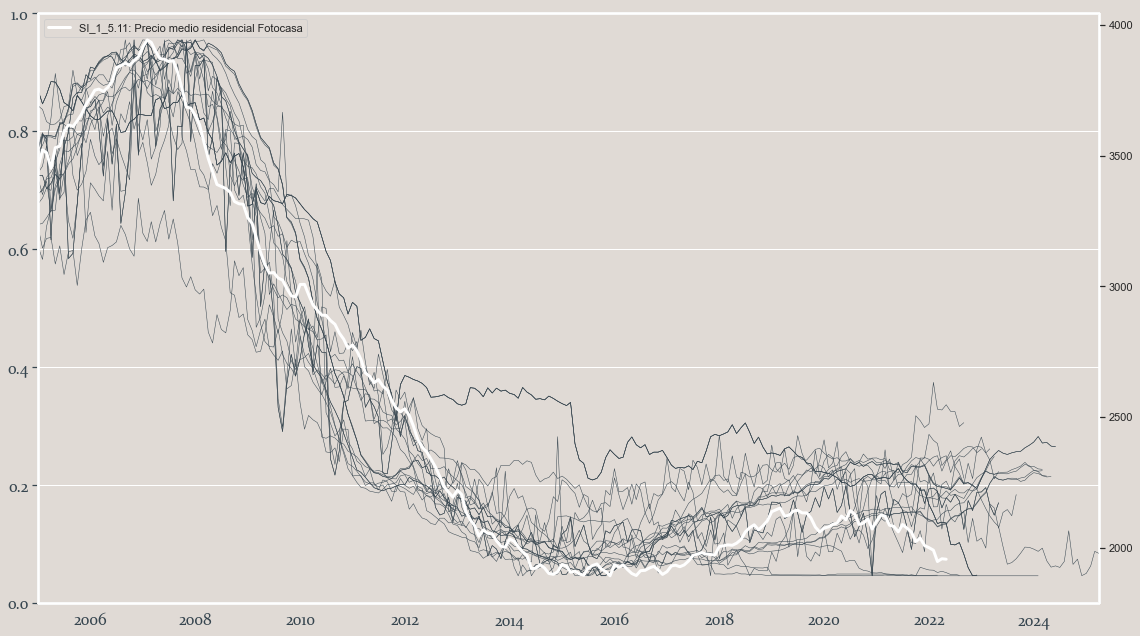

In [272]:
labelstyle = {'size':16, 'fontname':'Constantia','ha':'center', 'va':'center', 'labelpad':20}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}


def plot_pair_time_series(df, target, feature, value):
    target_series = df[target]
    feature_series = df[feature].shift(value['offset']).dropna()

    start = target_series.dropna().index[0]
    end = max(target_series.dropna().index[-1], feature_series.dropna().index[-1])

    feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    target_name = " ".join(facts[facts.SeriesAlias == target].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]
    units = facts[facts.SeriesAlias == feature].UnitDescription.values[0][:100]

    # Plot data
    fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
    ax2 = ax.twinx()
    p1, = ax.plot(target_series.axes[0], target_series, color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{target}: Precio Fotocasa')
    p2, = ax2.plot(feature_series.axes[0], feature_series, color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {feature_full_name}. {feature_units}')

    ax.grid()
    ax.set_facecolor(dp.rgb(dp.BEIGE))
    ax.set_ylabel(facts[facts.SeriesAlias == target].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
    ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

    # Change tick styles
    ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
    ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
    ax2.tick_params('y', colors=dp.rgb(dp.RED))
    for x in [ax, ax2]:
        for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

    ax.set_xlim([start, end])
    plt.legend(handles=[p1,p2], loc='upper left' )
    plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name} con un desfase de {value["offset"]} meses')
    plt.tight_layout()
    plt.savefig(f'EDA/plot/corr/series/{feature} - {target} - {units} - {round(value["correlation"], 3)}.png')
    plt.show()
    plt.close()


def plot_multiple_time_series(df, target, features, correlation):
    target_series = df[target]
    start = target_series.dropna().index[0]
    ends = [target_series.dropna().index[-1]]


    # feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    # target_name = " ".join(facts[facts.SeriesAlias == target].SeriesDescription.values[0].split('.')[-2:])[:100]
    # feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    # feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]


    # Set the color so I can see how much did the series has advanced
    cmap = get_cmap(len(range(-offset,offset+1,1)), name='coolwarm')

    # Plot data
    fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))

    for feature in features:
        feature_series = df[feature].shift(correlation[feature]['offset']).dropna()
        ends.append(feature_series.dropna().index[-1])
        ax2 = ax.twinx()
        p2, = ax2.plot(feature_series.axes[0], feature_series, color=dp.rgb(dp.CHARCOAL), linewidth=.5)
        # p2, = ax2.plot(feature_series.axes[0], feature_series, color=cmap(correlation[feature]['offset']+offset), linewidth=1)
        # print(correlation[feature]['offset'], correlation[feature]['offset']+offset, cmap(correlation[feature]['offset']+offset))
        ax.set_facecolor(dp.rgb(dp.BEIGE))
        # ax.set_ylabel(facts[facts.SeriesAlias == target].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
        # ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

        # Change tick styles
        ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
        ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
        ax2.tick_params('y', colors=dp.rgb(dp.RED))
        for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
        ax2.set_yticks([])

    # I create another axis for the main series so I can plot it above everything else
    ax3 = ax.twinx()
    p1, = ax3.plot(target_series.axes[0], target_series, color='white', linewidth=3, label = f'{target}: Precio medio residencial Fotocasa')
    end = max(ends)
    ax.set_xlim([start, end])
    ax.grid(axis='x')
    ax3.grid(axis='y')
    plt.legend(handles=[p1,p2], loc='upper left' )
    # plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name}')
    plt.tight_layout()
    plt.savefig(f'EDA/plot/corr/Series desfasadas hacia el futuro.png')
    plt.show()
    plt.close()

features = dresult.loc[(dresult['corr'] >= .96) & (dresult['off'] >= 0)].sort_values(by='off').name
plot_multiple_time_series(dg, target, features, correlation)

BE_19_16.3 {'correlation': 0.9677342028007208, 'pvalue': 6.884903842504716e-126, 'offset': 0}


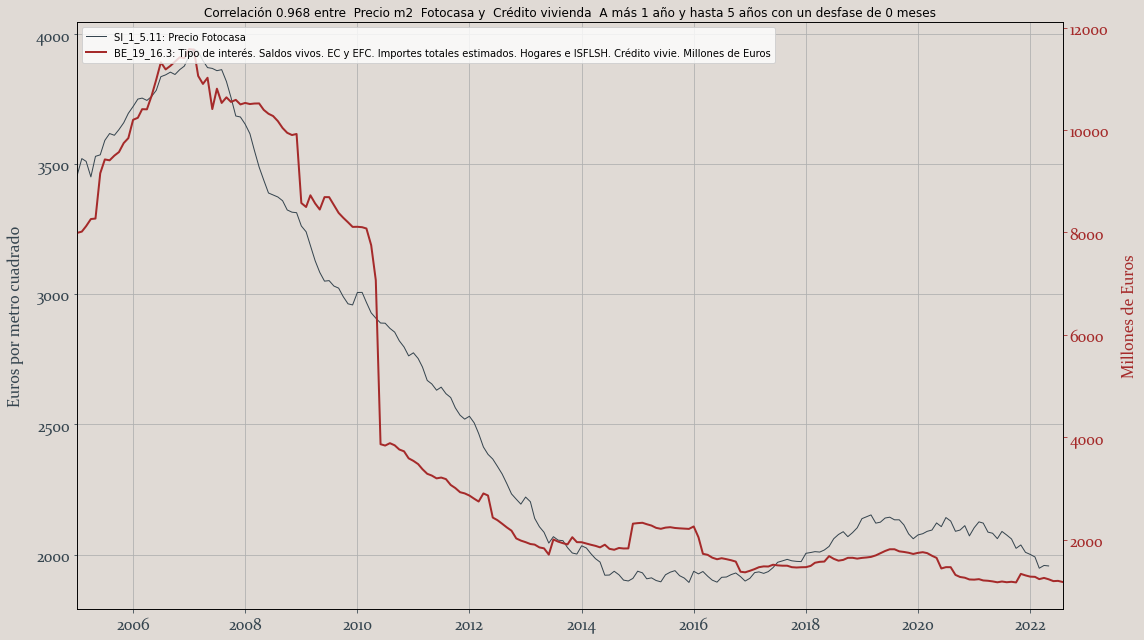

BE_6_6.3 {'correlation': 0.9766231675987447, 'pvalue': 3.5566457221503335e-140, 'offset': 0}


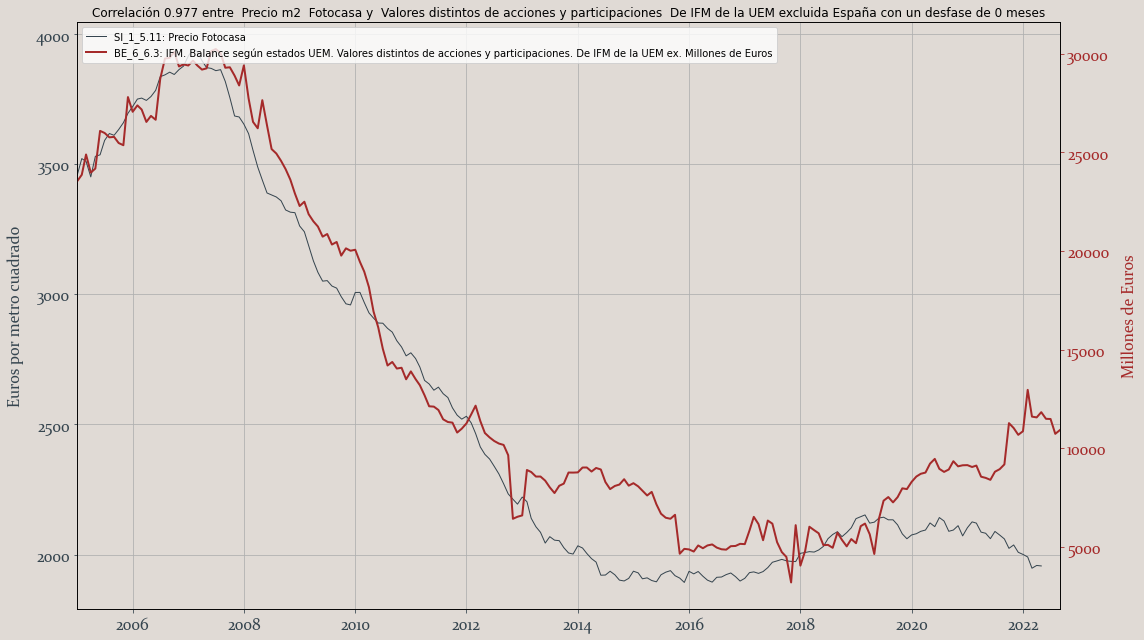

BE_19_17.11 {'correlation': 0.968160896557896, 'pvalue': 1.1394365289464198e-124, 'offset': 0}


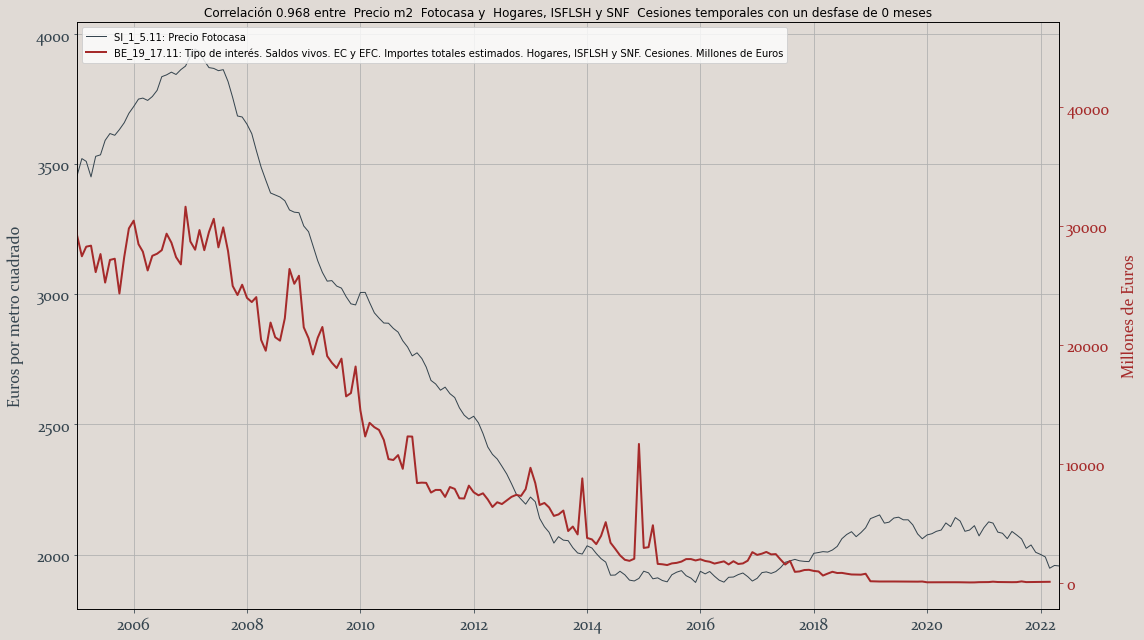

BE_4_53.4 {'correlation': 0.9618787829933393, 'pvalue': 1.593937197470042e-118, 'offset': 1}


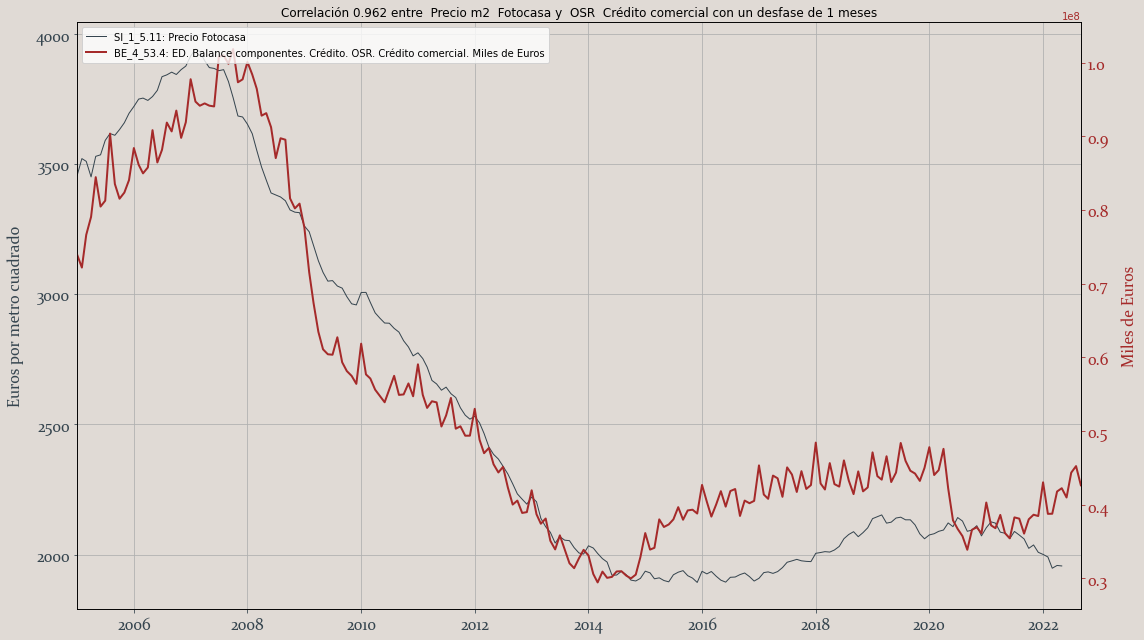

TC_1_1.3 {'correlation': 0.9657993046579447, 'pvalue': 2.5841310848094007e-123, 'offset': 3}


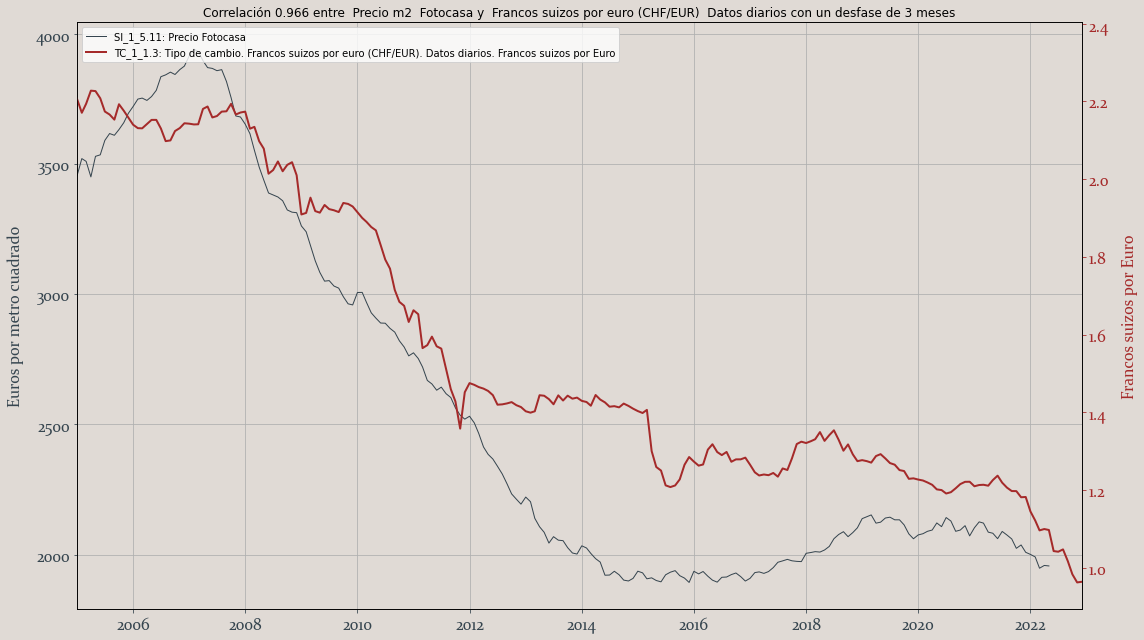

BE_20_1.3 {'correlation': 0.965799461461196, 'pvalue': 2.5829260430302736e-123, 'offset': 3}


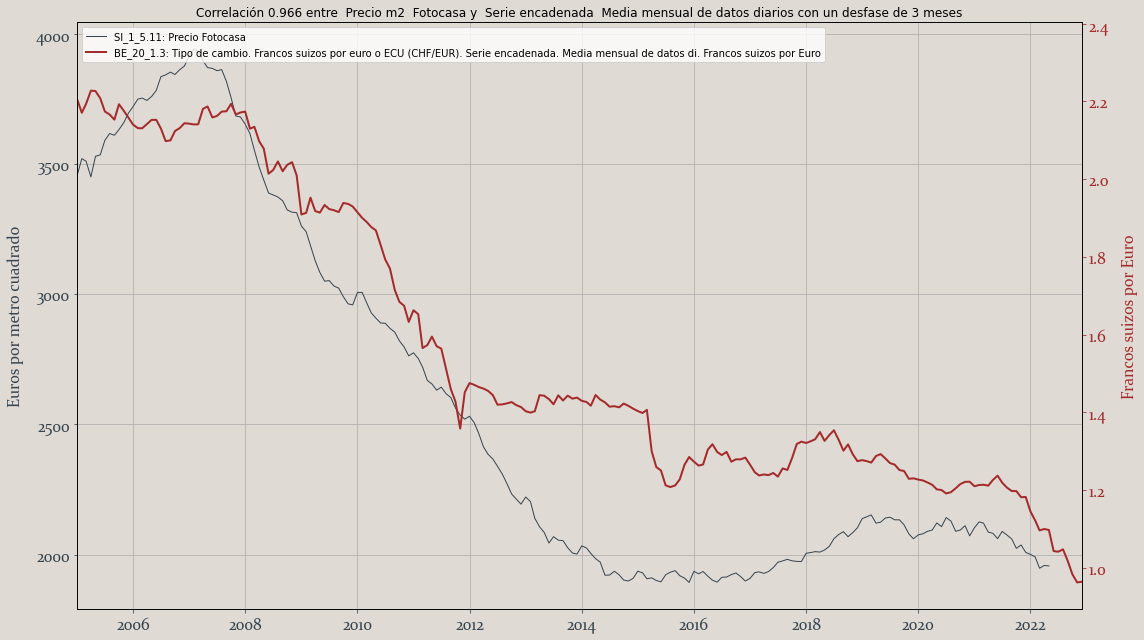

BE_1_16.3 {'correlation': 0.965799461461196, 'pvalue': 2.5829260430302736e-123, 'offset': 3}


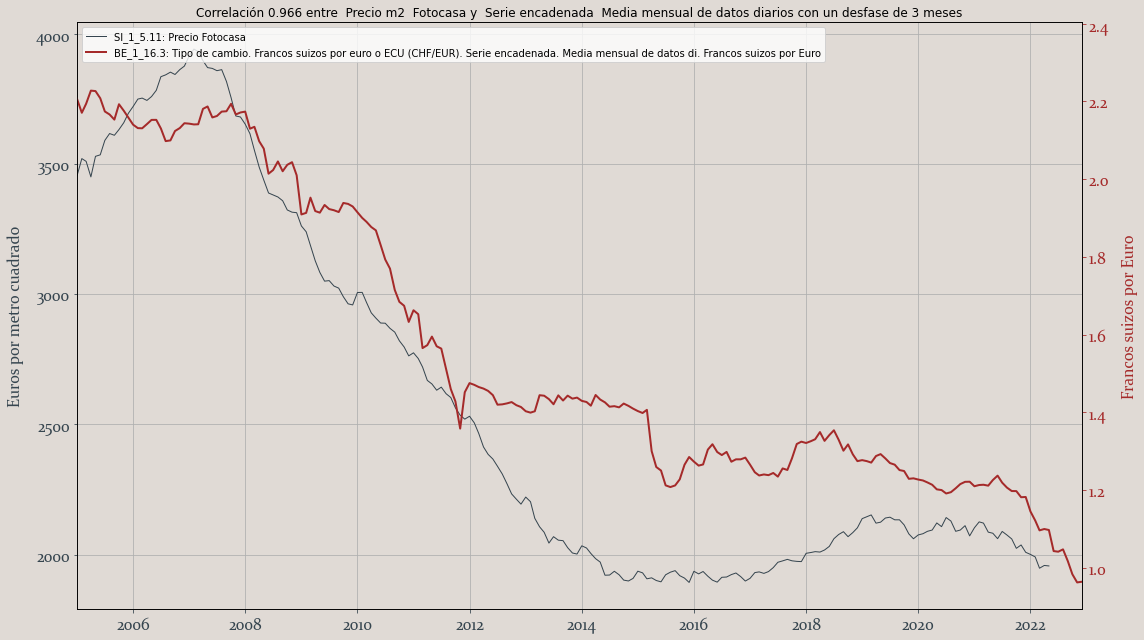

BE_24_19.14 {'correlation': 0.9749369114707591, 'pvalue': 4.407421366898247e-137, 'offset': 4}


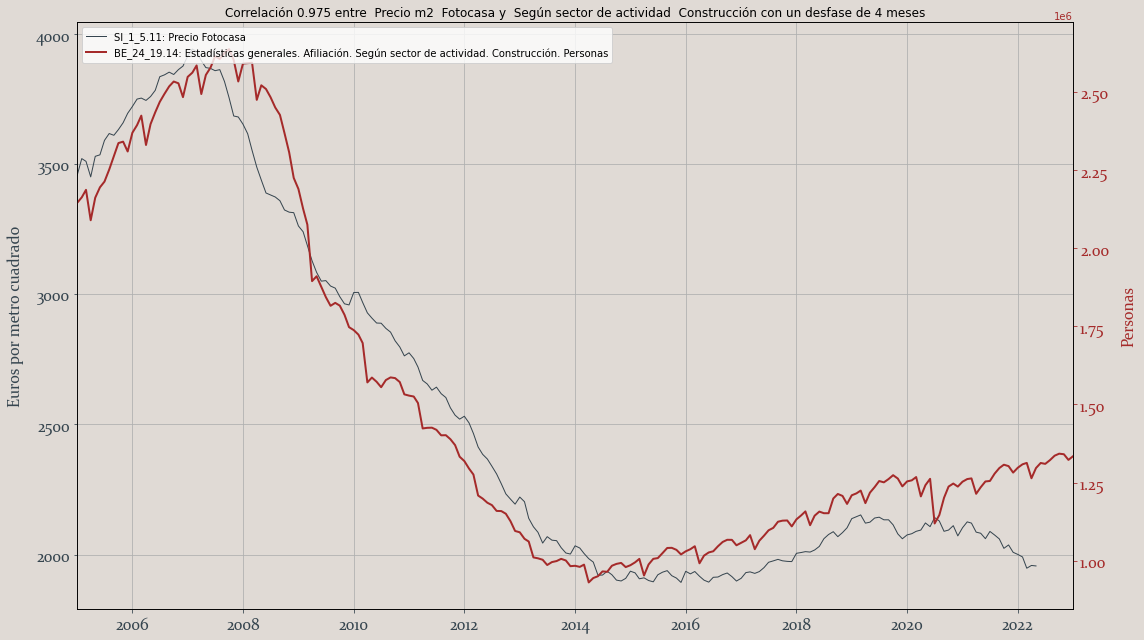

SI_1_1.50 {'correlation': 0.9770132628947548, 'pvalue': 6.358086194990061e-141, 'offset': 6}


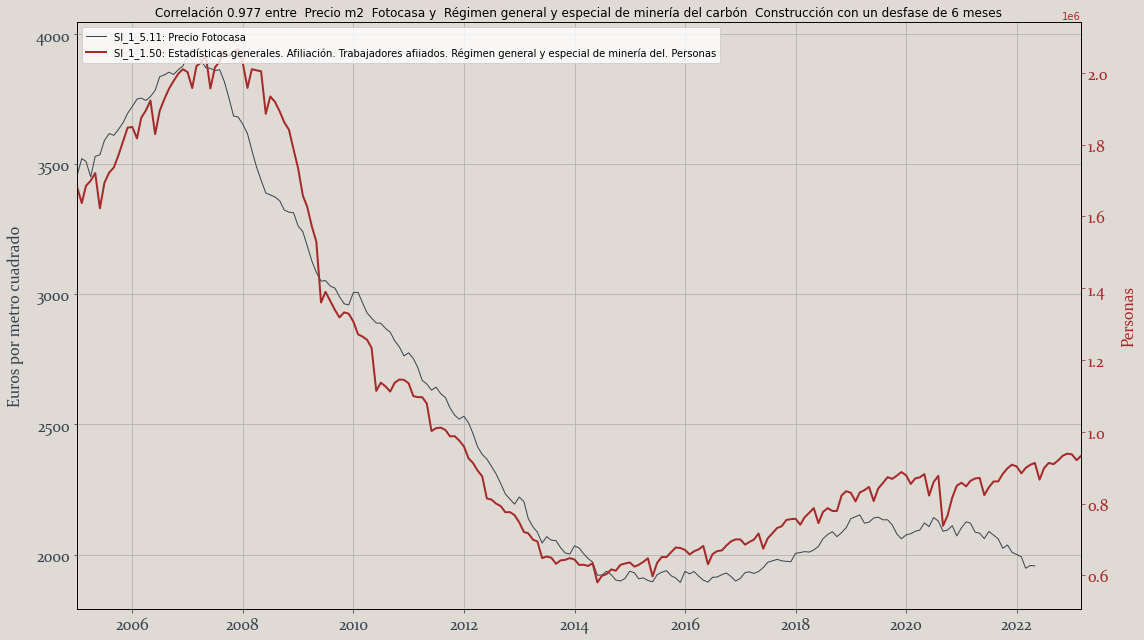

BE_23_11.8 {'correlation': 0.9669774319227108, 'pvalue': 7.295040544448095e-125, 'offset': 8}


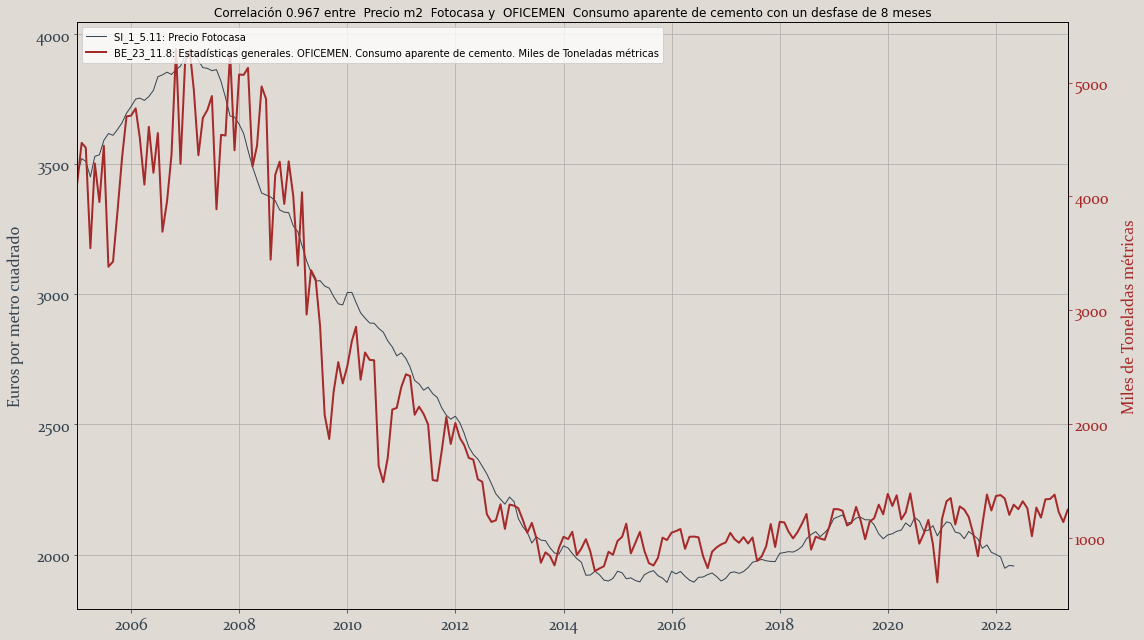

BE_23_11.5 {'correlation': 0.9626652874411468, 'pvalue': 1.9189026845190683e-119, 'offset': 8}


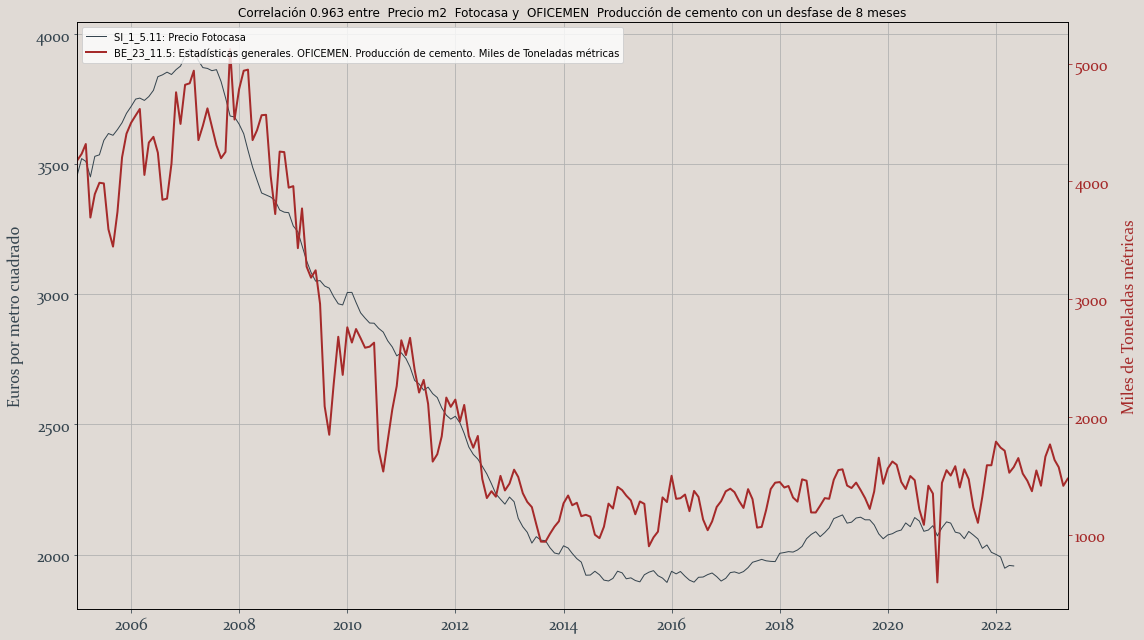

SI_1_1.47 {'correlation': 0.9669774319227108, 'pvalue': 7.295040544448095e-125, 'offset': 8}


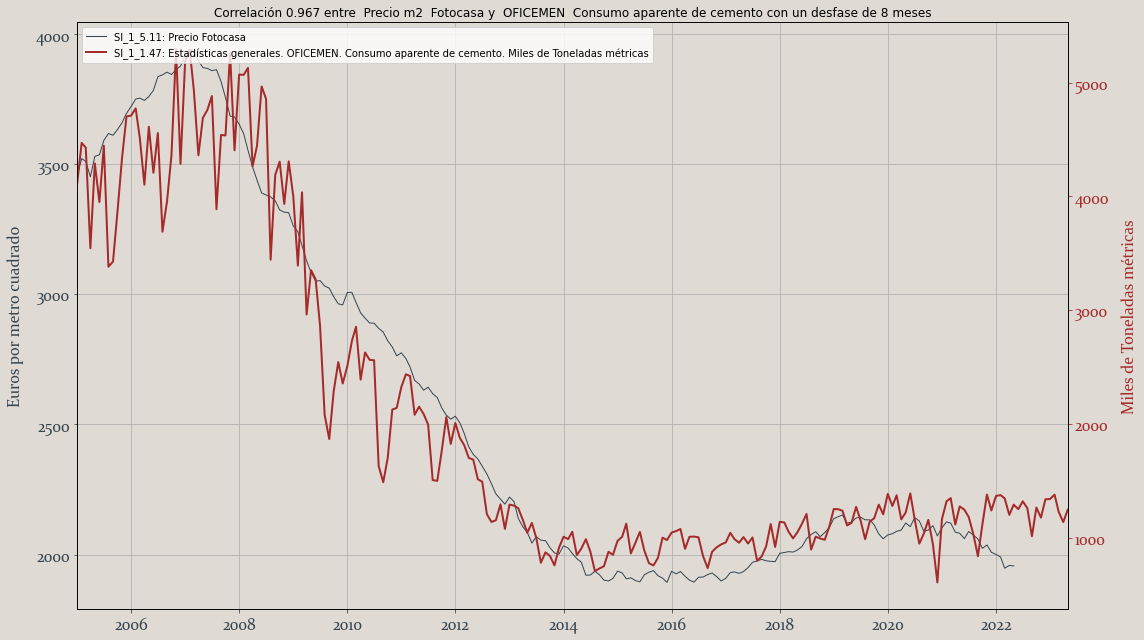

BE_8_13.4 {'correlation': 0.975033857632318, 'pvalue': 3.3805801466535107e-122, 'offset': 12}


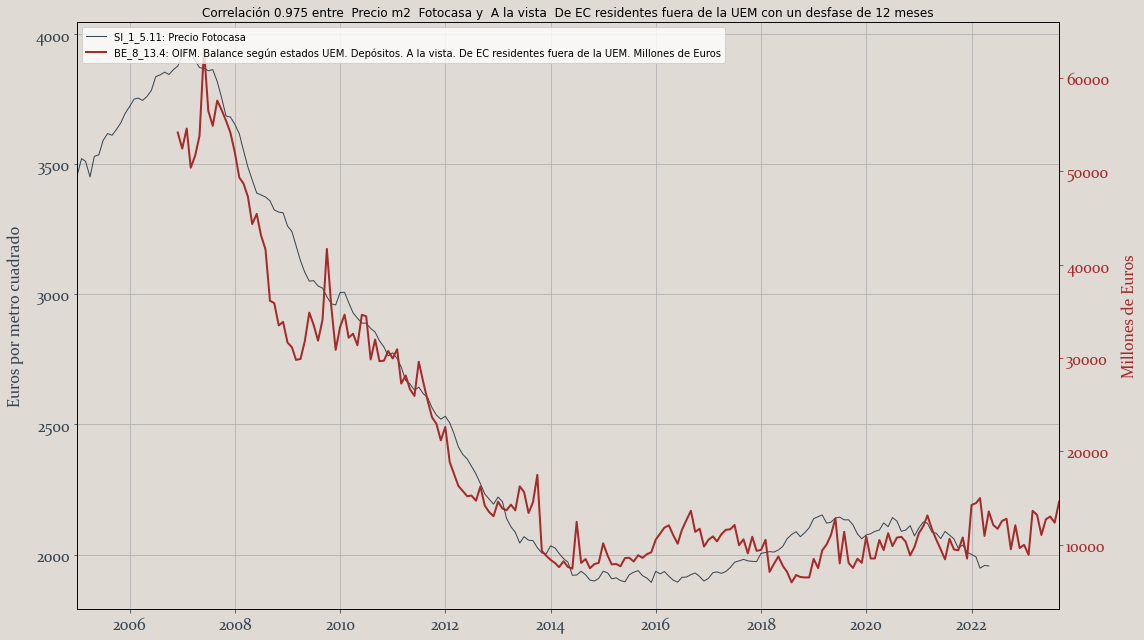

BE_8_22.15 {'correlation': 0.9646858882756826, 'pvalue': 6.720101888648733e-122, 'offset': 17}


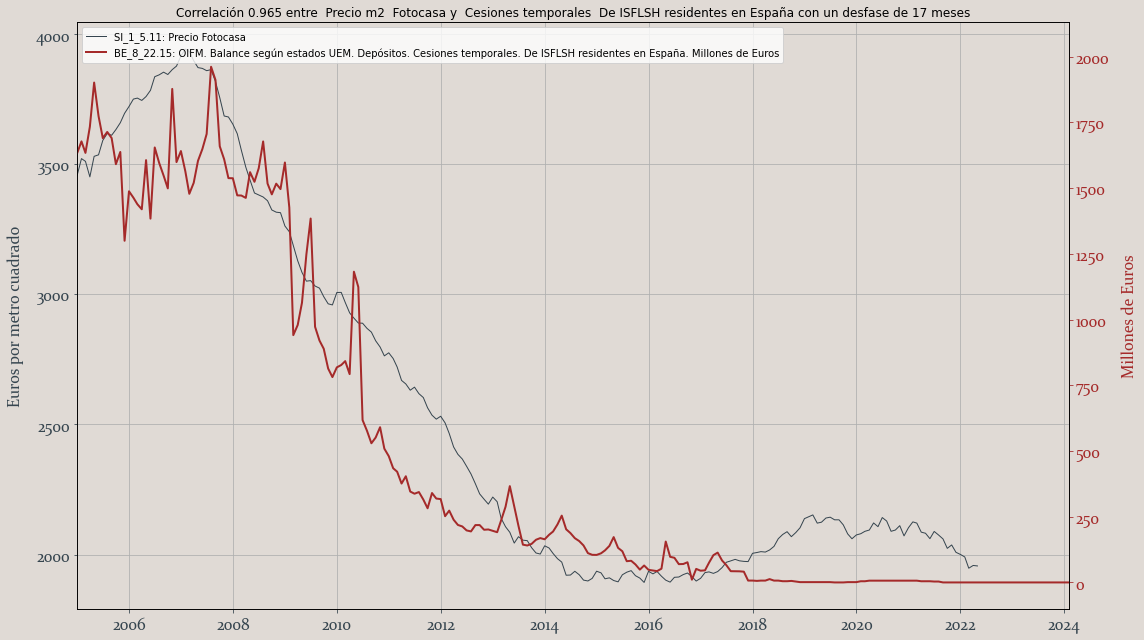

BE_3_21.6 {'correlation': 0.9757325031898683, 'pvalue': 1.629084238302781e-138, 'offset': 19}


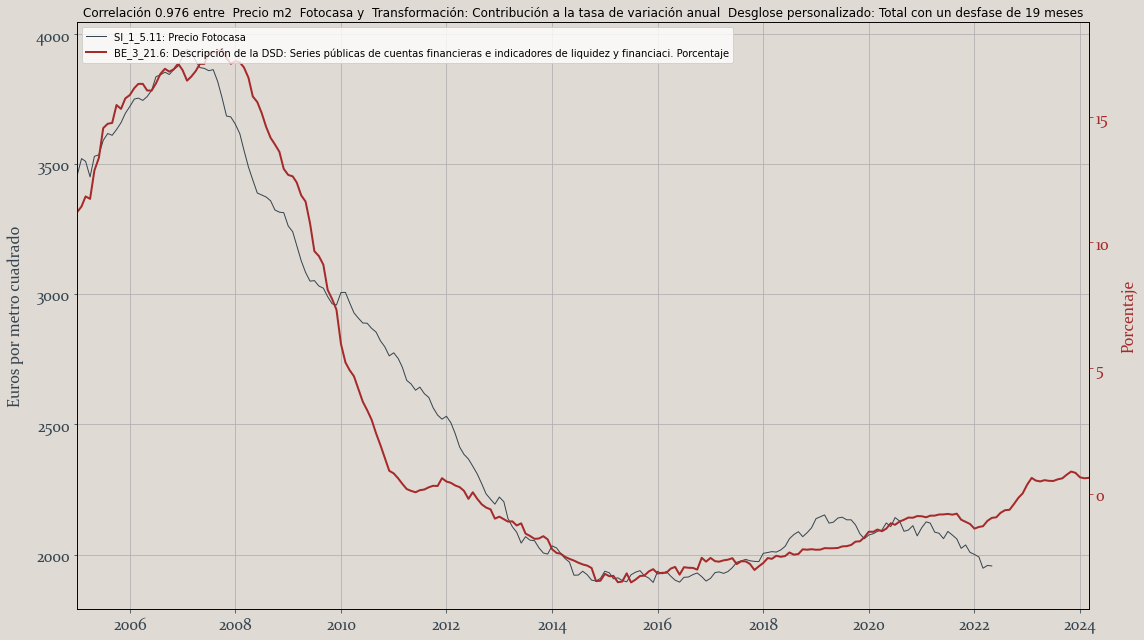

BE_3_19.14 {'correlation': 0.9606585027175581, 'pvalue': 3.9026261459403174e-117, 'offset': 19}


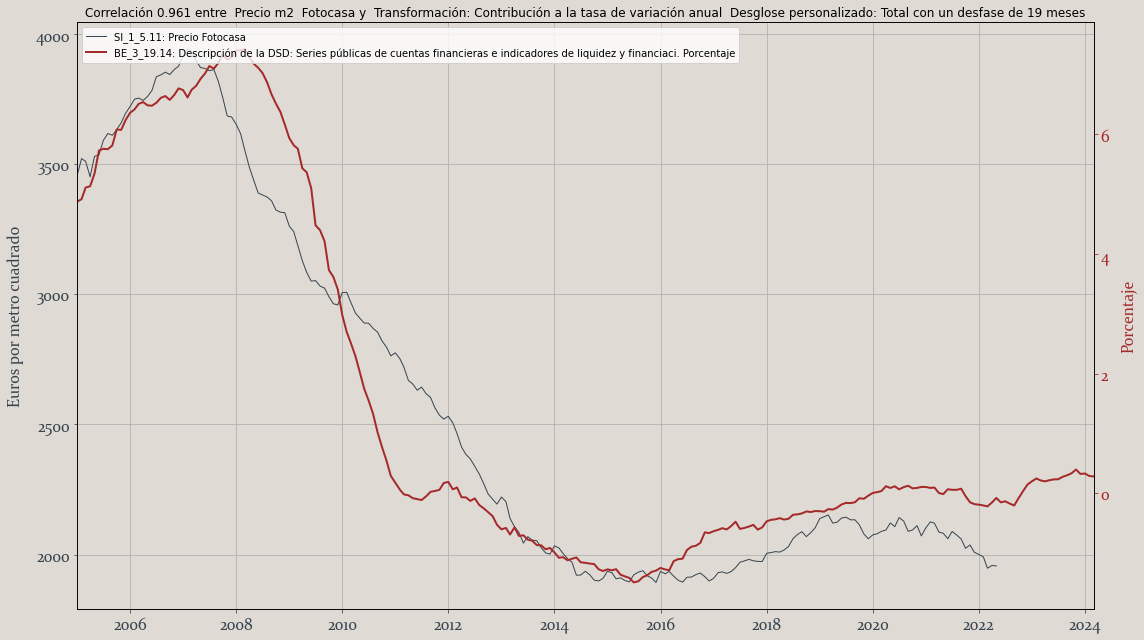

BE_3_21.5 {'correlation': 0.9768115005243265, 'pvalue': 1.5546873163044874e-140, 'offset': 21}


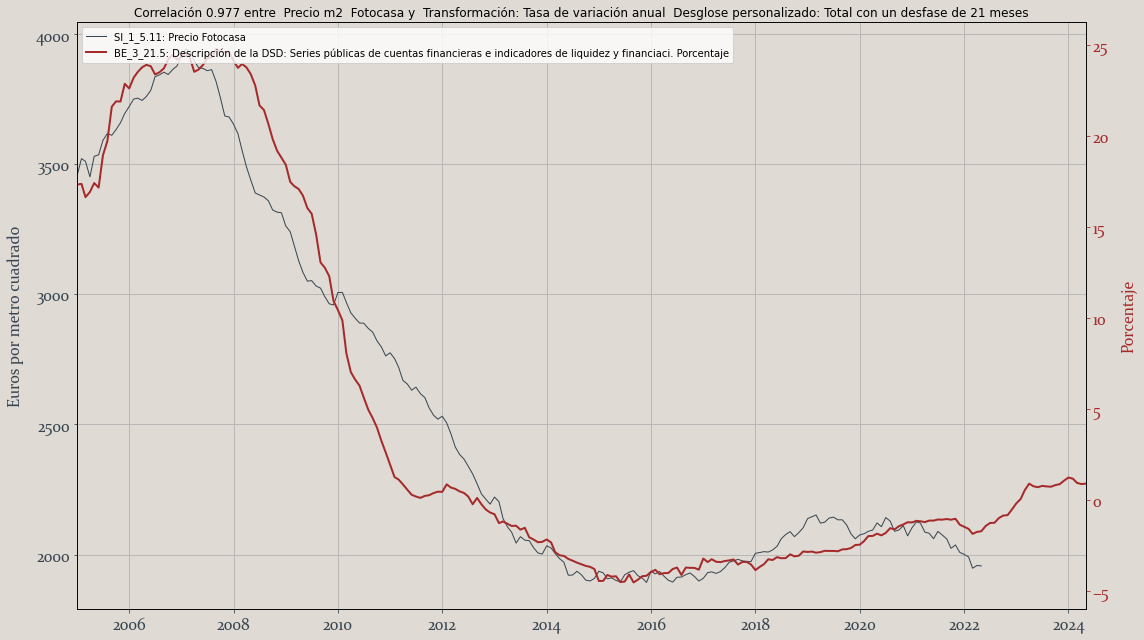

SI_1_5.57 {'correlation': 0.9766564264933659, 'pvalue': 3.074580208457017e-140, 'offset': 21}


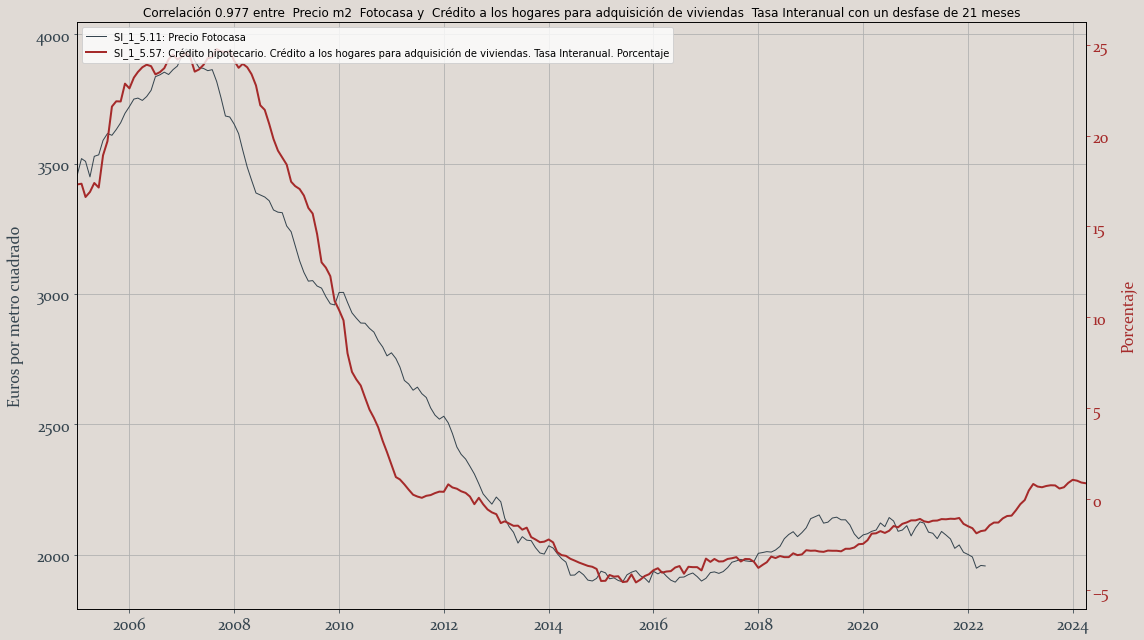

BE_3_21.3 {'correlation': 0.9691814284376673, 'pvalue': 6.420348942694469e-128, 'offset': 22}


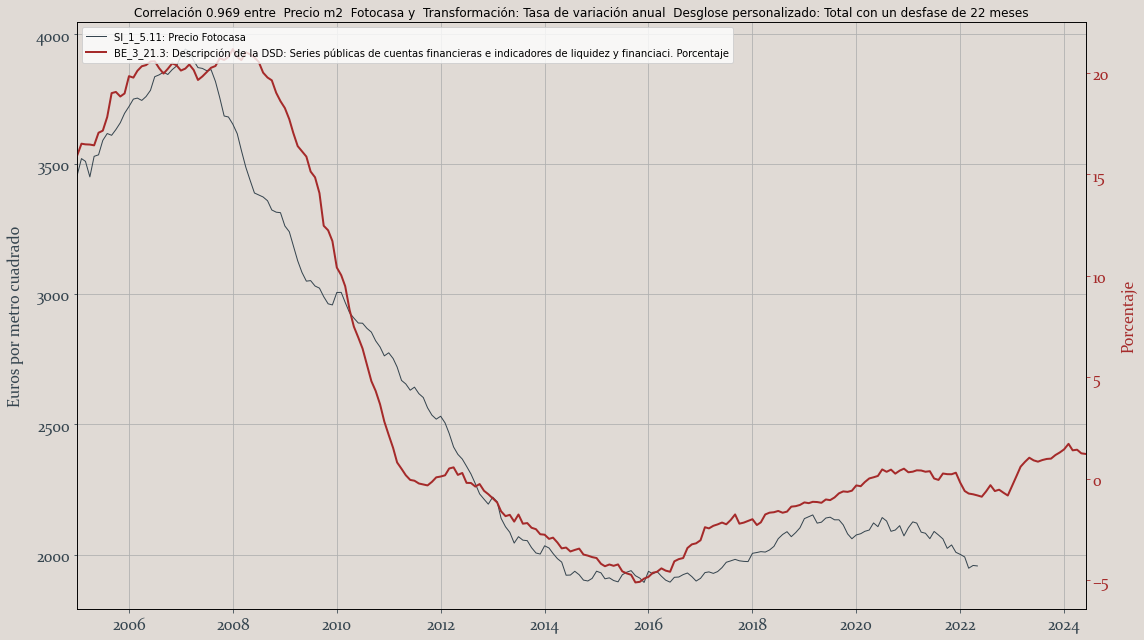

BE_3_19.7 {'correlation': 0.9691814284376673, 'pvalue': 6.420348942694469e-128, 'offset': 22}


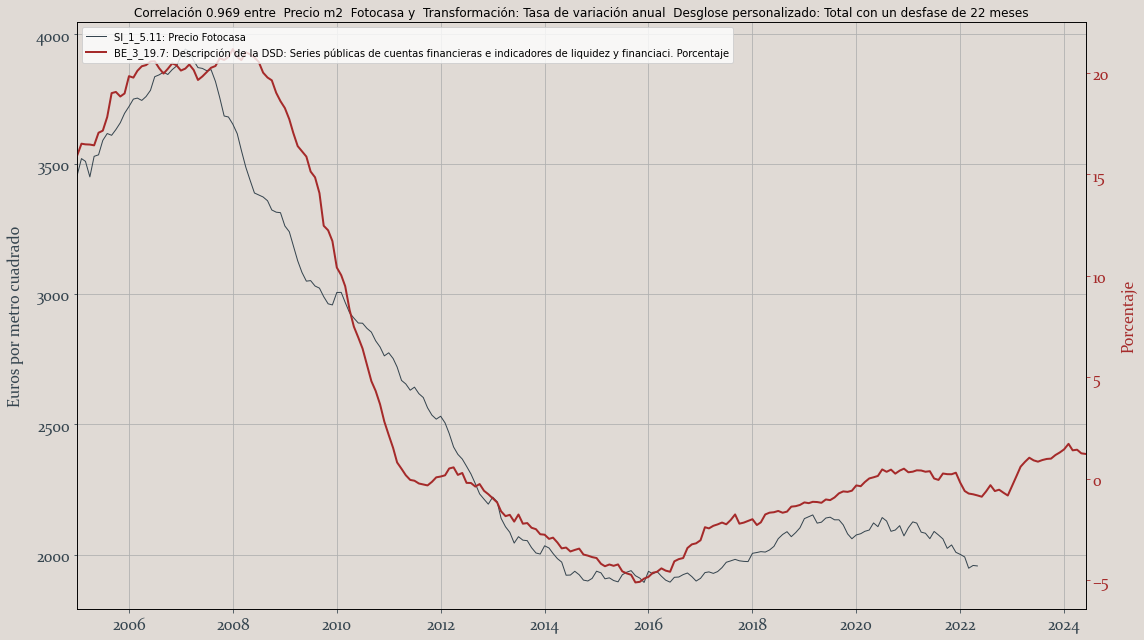

SI_1_3.34 {'correlation': 0.9694633064873153, 'pvalue': 2.516814472826996e-128, 'offset': 22}


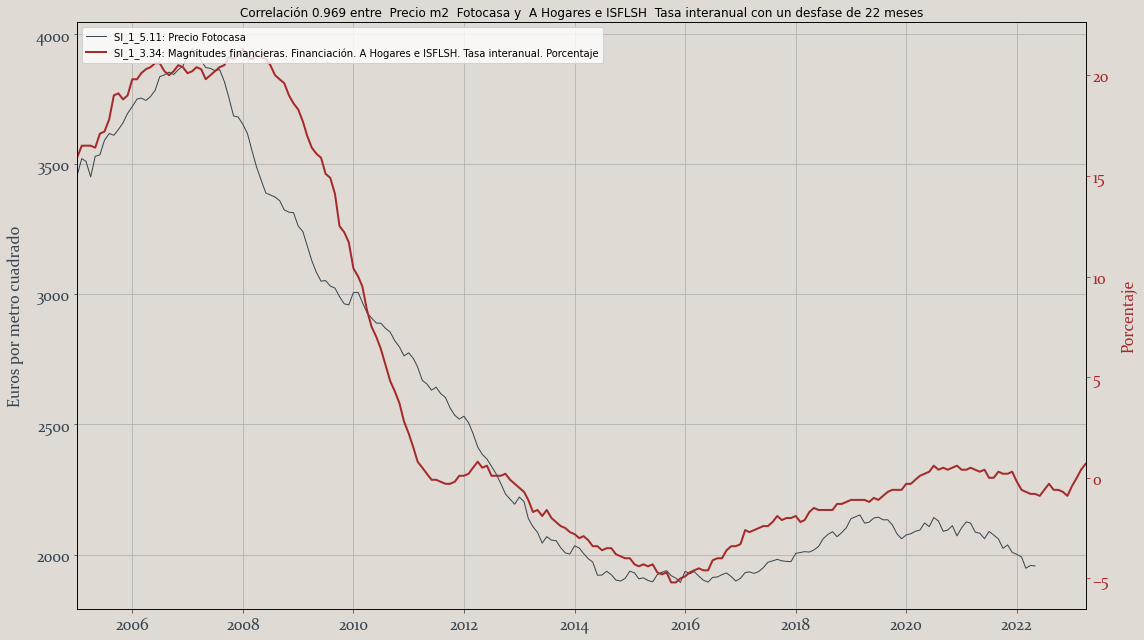

BE_24_20.18 {'correlation': 0.9850656239663321, 'pvalue': 3.96244885722116e-160, 'offset': 32}


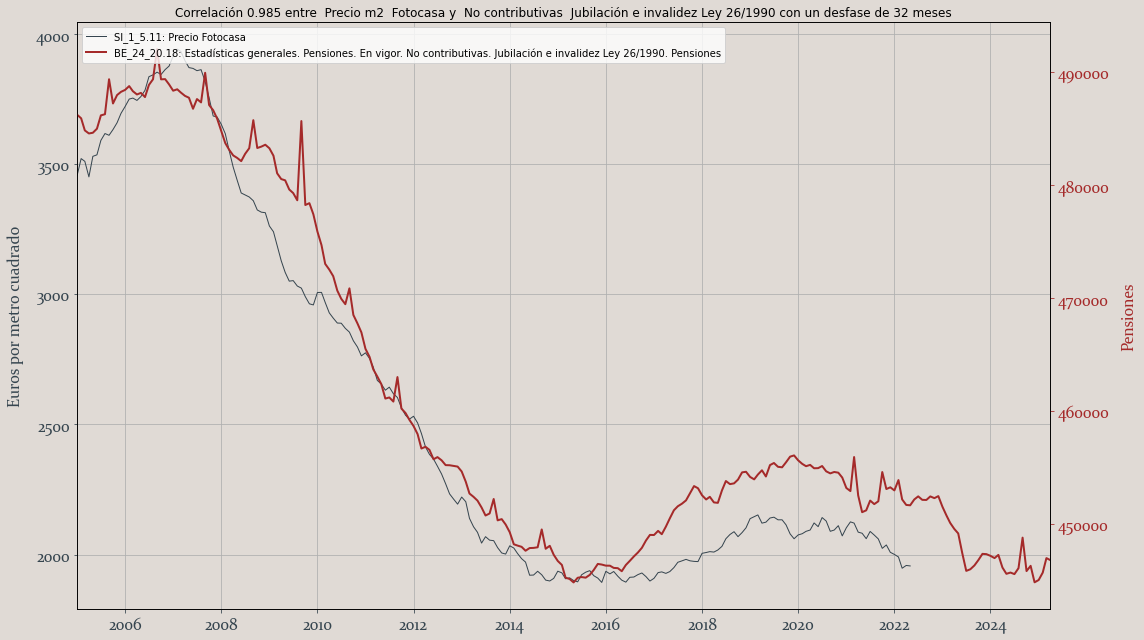

In [597]:
# for feature, value in correlation.items():
for feature in features:
    print(feature, correlation[feature])
    plot_pair_time_series(dg, target, feature, correlation[feature])

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(df[target], df[feature].shift(correlation[feature]['offset']), color='red')
# ax.scatter(df[target], df[feature], color='blue')
# plt.show()
# plt.close()
from matplotlib import rc, font_manager
labelstyle = {'size':16, 'fontname':'Constantia','ha':'center', 'va':'center', 'labelpad':20}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':dp.rgb(dp.CHARCOAL)}

i = 0
for feature, value in correlation.items():
    print(feature, correlation[feature])
    # feature = 'BE_3_21.3'
    # value = correlation[feature]
    
    # Process raw data
    # Both series may not share the same timespan, so
    # I want for it to start with the target series, and to end with latter in case there may be some hint for predictions
    target_series = df[target]
    feature_series = df[feature].shift(value['offset'])

    start = target_series.dropna().index[0]
    end = max(target_series.dropna().index[-1], feature_series.dropna().index[-1])

    feature_units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
    target_name = " ".join(facts[facts.SeriesAlias == select].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])[:100]
    feature_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0][:100]

    # Plot data
    fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
    ax2 = ax.twinx()
    p1, = ax.plot(df.axes[0], target_series, color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{select}: Precio Fotocasa')
    p2, = ax2.plot(df.axes[0], feature_series, color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {feature_full_name}. {feature_units}')

    ax.grid()
    ax.set_facecolor(dp.rgb(dp.BEIGE))
    ax.set_ylabel(facts[facts.SeriesAlias == select].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
    ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

    # Change tick styles
    ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
    ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
    ax2.tick_params('y', colors=dp.rgb(dp.RED))
    for x in [ax, ax2]:
        for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

    ax.set_xlim([start, end])
    plt.legend(handles=[p1,p2], loc='upper left' )
    plt.title(f'Correlación {round(value["correlation"], 3)} entre {target_name} y {feature_name}')
    plt.tight_layout()
    # # plt.savefig(f'EDA/plot/finance - ADJUSTED for inflation, WITHOUT time offset/{correlation} - {select} - {feature}.png')
    plt.show()
    plt.close()
    if i > 10:
        break
    i += 1

    # # How many values do coincide
    # base_has_values = df.loc[df[select].notna(),select].index
    # secondary_has_values = df.loc[base_has_values, feature].notna().sum()
    # pct_values = secondary_has_values/len(base_has_values)
    # start = df.loc[df[select].notna(),select].index[0]
    # end = df.loc[df[select].notna(),select].index[-1]
    # # print(start, df.loc[df[feature].notna(),feature].index[0], start == df.loc[df[feature].notna(),feature].index[0])
    # if pct_values > .9:
    #     correlation = sol[select][feature]
    #     correlation = round(correlation, 4)
    #     print(feature, correlation, pct_values)
    #     # break

In [ ]:
facts[facts.SeriesAlias == select].UnitDescription.values[0][:100]

In [ ]:
for feature in high_correlation_features:
    # How many values do coincide
    base_has_values = df.loc[df[select].notna(),select].index
    secondary_has_values = df.loc[base_has_values, feature].notna().sum()
    pct_values = secondary_has_values/len(base_has_values)
    start = df.loc[df[select].notna(),select].index[0]
    end = df.loc[df[select].notna(),select].index[-1]
    # print(start, df.loc[df[feature].notna(),feature].index[0], start == df.loc[df[feature].notna(),feature].index[0])
    if pct_values > .9:
        correlation = sol[select][feature]
        correlation = round(correlation, 4)
        print(feature, correlation, pct_values)
        units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
        base_name = " ".join(facts[facts.SeriesAlias == select].SeriesDescription.values[0].split('.')[-2:])
        feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])
        series_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0]
        fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
        ax2 = ax.twinx()

        p1, = ax.plot(df.axes[0], df[select], color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{select}: Precio Fotocasa')
        p2, = ax2.plot(df.axes[0], df[feature], color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {series_full_name}. {units}')

        ax.grid()
        ax.set_facecolor(dp.rgb(dp.BEIGE))
        ax.set_ylabel(facts[facts.SeriesAlias == select].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
        ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

        # ax.fill_between(df.axes[0], df[feature], color='w')
        # Change tick styles
        ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
        ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
        ax2.tick_params('y', colors=dp.rgb(dp.RED))
        for x in [ax, ax2]:
            for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
            for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

        start = df.loc[df[select].notna(),select].index[0]
        ax.set_xlim([start, end])
        plt.legend(handles=[p1,p2], loc='upper left' )
        plt.title(f'Correlación {correlation} entre {base_name} y {feature_name}')
        plt.tight_layout()
        plt.savefig(f'EDA/plot/finance - ADJUSTED for inflation, WITHOUT time offset/{correlation} - {select} - {feature}.png')
        # plt.show()
        plt.close()
        # break

In [ ]:
from scipy import stats
# Y and Z are numpy arrays or lists of variables 

# feature = high_correlation_features[0]
for feature in high_correlation_features:
    correlations = {}
    for offset in range(-36,32,1):
        offseted_ts = df[feature].shift(offset)
        corr = pd.DataFrame({0:df[select], 1:offseted_ts}).corr()[0][1]
        # stats.pearsonr(df[select], offseted_ts)
        correlations[offset] = corr
        # if offset == 0:
        #     print(corr)
        # print(offset, corr)

    m = max([value for key, value in correlations.items()])
    for key, value in correlations.items():
        base_has_values = df.loc[df[feature].shift(key).notna(),select].index
        secondary_has_values = df.loc[base_has_values, feature].notna().sum()

        pct_values = secondary_has_values/len(base_has_values)
        # print(pct_values)
        start = df.loc[df[select].notna(),select].index[0]
        end = df.loc[df[select].notna(),select].index[-1]
        # print(start, df.loc[df[feature].notna(),feature].index[0], start == df.loc[df[feature].notna(),feature].index[0])
        if (pct_values > .9) and (value == m) and (pd.notna(pct_values)):
            print(value-correlations[0])
            # fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
            # ax2 = ax.twinx()
            # p1, = ax.plot(df.axes[0], df[select], color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{select}: Precio Fotocasa')
            # p2, = ax2.plot(df.axes[0], df[feature].shift(key), color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {series_full_name}. {units}')
            # p2, = ax2.plot(df.axes[0], offseted_ts, color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {series_full_name}. {units}')
            # plt.show()
            # plt.close()
            units = facts[facts.SeriesAlias == feature].UnitDescription.values[0]
            base_name = " ".join(facts[facts.SeriesAlias == select].SeriesDescription.values[0].split('.')[-2:])
            feature_name = " ".join(facts[facts.SeriesAlias == feature].SeriesDescription.values[0].split('.')[-2:])
            series_full_name = facts[facts.SeriesAlias == feature].SeriesDescription.values[0]
            fig, ax = plt.subplots(figsize = (16,9), facecolor=dp.rgb(dp.BEIGE))
            ax2 = ax.twinx()

            p1, = ax.plot(df.axes[0], df[select], color=dp.rgb(dp.CHARCOAL), linewidth=1, label = f'{select}: Precio Fotocasa')
            p2, = ax2.plot(df.axes[0], df[feature].shift(key), color=dp.rgb(dp.RED), linewidth=2, label=f'{feature}: {series_full_name}. {units}')
            # p2, = ax2.plot(df.axes[0], df[feature].shift(0), color=dp.rgb(dp.WHITE), linewidth=2, label=f'{feature}: {series_full_name}. {units}')
            
            ax.grid()
            ax.set_facecolor(dp.rgb(dp.BEIGE))
            ax.set_ylabel(facts[facts.SeriesAlias == select].UnitDescription.values[0], color=dp.rgb(dp.CHARCOAL), **labelstyle)
            ax2.set_ylabel(facts[facts.SeriesAlias == feature].UnitDescription.values[0], color=dp.rgb(dp.RED), **labelstyle)

            # ax.fill_between(df.axes[0], df[feature], color='w')
            # Change tick styles
            ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
            ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
            ax2.tick_params('y', colors=dp.rgb(dp.RED))
            for x in [ax, ax2]:
                for label in x.get_xticklabels(): label.set_fontproperties(ticks_style)
                for label in x.get_yticklabels(): label.set_fontproperties(ticks_style)

            start = df.loc[df[select].notna(),select].index[0]
            ax.set_xlim([start, end])
            plt.legend(handles=[p1,p2], loc='upper left' )
            plt.title(f'Correlación {value} entre {base_name} y {feature_name}, offset {key} meses')
            plt.tight_layout()
            # plt.savefig(f'EDA/plot/finance - ADJUSTED for inflation, WITHOUT time offset/{correlation} - {select} - {feature}.png')
            plt.show()
            plt.close()
    # break
    # correlations.items()

Calcular correlaciones con series de viviendas

In [89]:
# Constants
import sqlite3
dbpath = 'data/real_estate.sqlite'
con = sqlite3.connect(dbpath)
dr = pd.read_sql_query(f"SELECT * from Series", con)
dr.Fecha_Compraventa = pd.to_datetime(dr.Fecha_Compraventa, format='%Y-%m-%d')
dr.set_axis(dr.Fecha_Compraventa, inplace=True)
dr.drop(columns='Fecha_Compraventa', inplace=True)
dr

Guadalajara_pluri_libre_(1950, 2000]_(100, 200]  \
Fecha_Compraventa                                                    
2010-01-01                                                  1150.0   
2010-02-01                                                  2000.0   
2010-03-01                                                  2200.0   
2010-04-01                                                  2400.0   
2010-05-01                                                  1600.0   
...                                                            ...   
2021-04-01                                                  1250.0   
2021-05-01                                                  1100.0   
2021-06-01                                                  1600.0   
2021-07-01                                                  1600.0   
2021-08-01                                                     NaN   

                   Guadalajara_pluri_libre_(1950, 2000]_(60, 80]  \
Fecha_Compraventa                                                  
2010-01-01                                                1700.0   
2010-02-01                                                2500.0   
2010-03-01                                                2075.0   
2010-04-01                                                1650.0   
2010-05-01                                                1500.0   
...                                                          ...   
2021-04-01                                                1000.0   
2021-05-01                                                1200.0   
2021-06-01                                                1200.0   
2021-07-01                                                1200.0   
2021-08-01                                                   NaN   

                   Guadalajara_pluri_libre_(1950, 2000]_(80, 100]  \
Fecha_Compraventa                                                   
2010-01-01                                                    NaN   
2010-02-01                                                 2100.0   
2010-03-01                                                 1700.0   
2010-04-01                                                 2100.0   
2010-05-01                                                 1900.0   
...                                                           ...   
2021-04-01                                                 1100.0   
2021-05-01                                                 1300.0   
2021-06-01                                                 1200.0   
2021-07-01                                                 1200.0   
2021-08-01                                                    NaN   

                   Guadalajara_pluri_libre_(2000, 2022]_(100, 200]  \
Fecha_Compraventa                                                    
2010-01-01                                                  2400.0   
2010-02-01                                                  2550.0   
2010-03-01                                                  2200.0   
2010-04-01                                                  2900.0   
2010-05-01                                                  2450.0   
...                                                            ...   
2021-04-01                                                  1200.0   
2021-05-01                                                  1600.0   
2021-06-01                                                  1450.0   
2021-07-01                                                  1450.0   
2021-08-01                                                     NaN   

                   Guadalajara_pluri_libre_(2000, 2022]_(60, 80]  \
Fecha_Compraventa                                                  
2010-01-01                                                2550.0   
2010-02-01                                                2200.0   
2010-03-01                                                3100.0   
2010-04-01                                                2800.0   
2010-0

In [308]:
features = list(dresult.sort_values(by='off').name)

In [310]:
ds = pd.concat([df[feature].shift(correlation[feature]['offset']).dropna() for feature in features], axis=1)
ds = pd.merge(left=ds,right=dr,how='inner',left_index=True,right_index=True)
ds.head(5)

BE_8_31.13     BE_1_13.5      BE_8_18.3     BE_4_14.4  \
2010-01-01           NaN  2.379900e+06  463066.980899           NaN   
2010-02-01           NaN  2.346258e+06  441000.734641           NaN   
2010-03-01  3.460081e+06  2.330979e+06  435754.770640  7.165081e+08   
2010-04-01           NaN  2.309400e+06  430342.232250           NaN   
2010-05-01           NaN  2.287912e+06  423535.395229           NaN   

               BE_4_14.5      BE_6_4.5      BE_6_3.9      BE_6_3.8  \
2010-01-01           NaN  21781.392733  1.860680e+06  1.878147e+06   
2010-02-01           NaN  19881.108550  1.825722e+06  1.843586e+06   
2010-03-01  6.867994e+08  18917.095070  1.819743e+06  1.837640e+06   
2010-04-01           NaN  18959.639022  1.788019e+06  1.804778e+06   
2010-05-01           NaN  17455.562743  1.762414e+06  1.778864e+06   

               BE_8_31.2     BE_4_14.6  ...  Valdemoro_pluri_libre  \
2010-01-01  3.168602e+06           NaN  ...                    NaN   
2010-02-01  3.145359e+06           NaN  ...                    NaN   
2010-03-01  3.142532e+06  6.760317e+08  ...                    NaN   
2010-04-01  3.097399e+06           NaN  ...                    NaN   
2010-05-01  3.041031e+06           NaN  ...                    NaN   

            Valdemoro_uni adosado_libre  Ávila_pluri_libre  Ávila_pluri_vpo  \
2010-01-01                          NaN             2000.0           1500.0   
2010-02-01                          NaN             1900.0           1560.0   
2010-03-01                          NaN             2200.0           1620.0   
2010-04-01                          NaN             2100.0           1680.0   
2010-05-01                          NaN             2300.0           1740.0   

            Ávila_uni adosado_libre  pluri_libre  pluri_vpo  \
2010-01-01                   1700.0       3600.0     2300.0   
2010-02-01                   1750.0       3600.0     2300.0   
2010-03-01                   1750.0       3500.0     2400.0   
2010-04-01                   1600.0       3600.0     2300.0   
2010-05-01                   1700.0       3400.0     2100.0   

            uni adosado_libre  uni adosado_vpo  uni chalet_libre  
2010-01-01             2100.0           1200.0            4000.0  
2010-02-01             1900.0           2500.0            3600.0  
2010-03-01             2150.0           1650.0            4950.0  
2010-04-01             2800.0           3100.0            3650.0  
2010-05-01             1800.0           3050.0            3550.0  

[5 rows x 434 columns]

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hex2color

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict


In [311]:
ordered_columns = ds.corr().sum().sort_values(ascending=False).index.values
corr = ds[ordered_columns].corr()

hc = [dp.hex_color(dp.GLAUCUS), '#000', '#fff', dp.hex_color(dp.RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

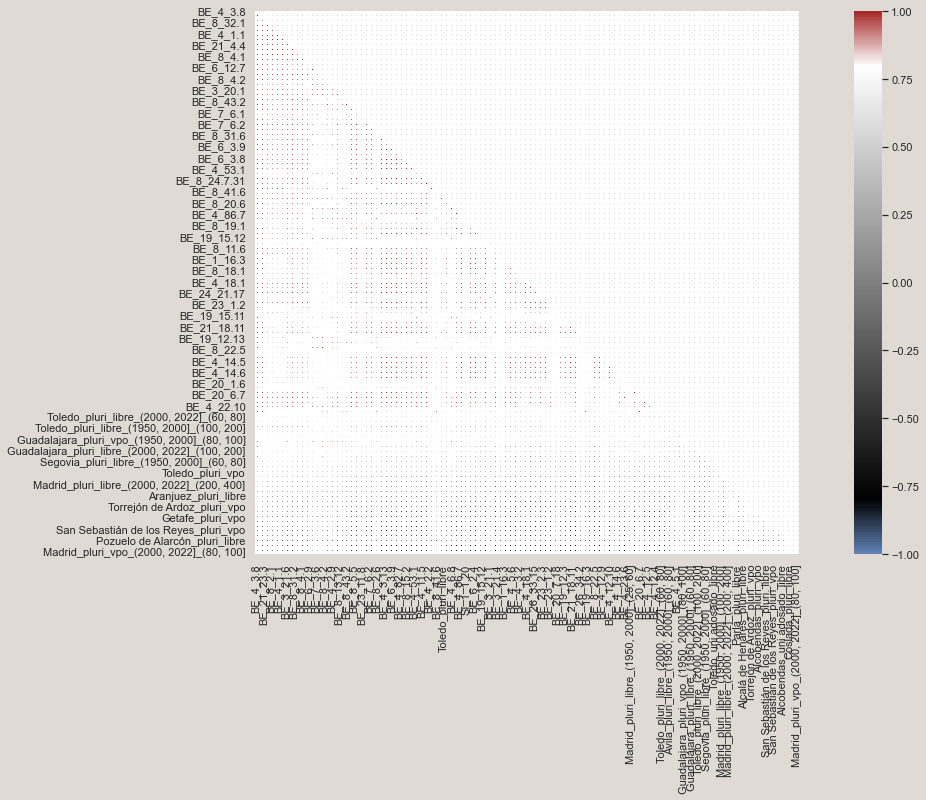

In [291]:
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':False,'center':0,'square':True}
fig, ax = plt.subplots(figsize = (20,10), facecolor=dp.rgb(dp.BEIGE))
sns.heatmap(corr, ax=ax, **plot_properties)

In [371]:
sol = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().sort_values(ascending=False).reset_index()

# Me quedo con las variables que son un cruce entre información financiera e inmobiliaria
sol['mix'] = ((sol.level_0.isin(list(features))) & (~sol.level_1.isin(list(features)))) | ((~sol.level_0.isin(list(features))) & (sol.level_1.isin(list(features))))
sol = sol.loc[sol.mix].copy()

# Crear columna solo con nombres de series financieras
sol.loc[sol.level_0.isin(features), 'finance'] = sol.loc[sol.level_0.isin(features), 'level_0']
sol.loc[sol.level_1.isin(features), 'finance'] = sol.loc[sol.level_1.isin(features), 'level_1']

sol.loc[~sol.level_0.isin(features), 'architecture'] = sol.loc[~sol.level_0.isin(features), 'level_0']
sol.loc[~sol.level_1.isin(features), 'architecture'] = sol.loc[~sol.level_1.isin(features), 'level_1']

sol_2 = pd.DataFrame({'corr':sol[0], 'architecture':sol.architecture, 'finance':sol.finance}).sort_values(by='corr', ascending=False)
resultordered = pd.merge(left=sol_2, right=facts[['SeriesDescription','SeriesAlias']], how='inner', left_on='finance', right_on='SeriesAlias').drop(columns=['SeriesAlias',]).sort_values(by='corr', ascending=False)

# resultordered = resultordered.loc[(resultordered['corr']>.8) | (resultordered['corr'] < -.8)]
resultordered


corr                              architecture      finance  \
0      0.958082                               pluri_libre   BE_21_23.3   
108    0.950914                               pluri_libre    BE_25_6.1   
216    0.948153                               pluri_libre   BE_8_32.12   
324    0.947113                               pluri_libre   BE_8_42.12   
432    0.945397  Madrid_pluri_libre_(1950, 2000]_(60, 80]     BE_4_A.4   
...         ...                                       ...          ...   
33257 -0.790130                        Alcorcón_pluri_vpo  BE_21_18.11   
33149 -0.790130                        Alcorcón_pluri_vpo   BE_21_18.8   
22133 -0.806789                       Coslada_pluri_libre    BE_4_14.8   
20729 -0.807791                       Coslada_pluri_libre    BE_4_13.8   
20621 -0.807791                       Coslada_pluri_libre   BE_8_19.10   

                                       SeriesDescription  
0      Emisiones de valores. Valores representativos ...  
108    Estadísticas generales. IPRI. Industrias manuf...  
216    EC y EFC. Balance según estados UEM. Pasivo. E...  
324    ED. Balance según estados UEM. Pasivo. Pasivos...  
432    EC y EFC. Balance agregado estados supervisión...  
...                                                  ...  
33257  Emisiones de valores. Valores representativos ...  
33149  Emisiones de valores. Valores representativos ...  
22133  ED. Créditos a OSR por finalidades. Otras fina...  
20729  EC y EFC. Créditos a OSR por finalidades. Otra...  
20621  EC y EFC. Créditos a OSR por finalidades. Otra...  

[35202 rows x 4 columns]

Qué series de viviendas están más correlacionadas con índices económicos ?

In [372]:
cor_pos = resultordered.loc[resultordered['corr']>.9]
cor_pos.groupby('architecture').count().sort_values(by='corr',ascending=False)

corr  finance  SeriesDescription
architecture                                                               
pluri_libre                                  53       53                 53
uni chalet_libre                             21       21                 21
Madrid_pluri_libre_(1950, 2000]_(60, 80]      6        6                  6
Madrid_pluri_libre                            5        5                  5
Madrid_pluri_libre_(1800, 1950]_(25, 60]      5        5                  5
Madrid_pluri_libre_(1950, 2000]_(80, 100]     5        5                  5
Toledo_pluri_libre                            4        4                  4
Ávila_pluri_libre                             4        4                  4
Ávila_uni adosado_libre                       2        2                  2
Madrid_pluri_libre_(1950, 2000]_(25, 60]      1        1                  1
Segovia_pluri_libre                           1        1                  1

In [373]:
cor_neg = resultordered.loc[resultordered['corr'] < .5]
cor_neg.groupby('architecture').count().sort_values(by='corr',ascending=False)
cor_neg

corr                               architecture       finance  \
25845  0.499942                          Parla_pluri_libre  BE_8_24.7.31   
24572  0.499939                    Ávila_uni adosado_libre    BE_3_19.14   
6420   0.499935                    Fuenlabrada_pluri_libre     BE_4_3.10   
2413   0.499918  Segovia_pluri_libre_(1950, 2000]_(60, 80]      BE_7_3.7   
2518   0.499918  Segovia_pluri_libre_(1950, 2000]_(60, 80]      BE_7_3.6   
...         ...                                        ...           ...   
33257 -0.790130                         Alcorcón_pluri_vpo   BE_21_18.11   
33149 -0.790130                         Alcorcón_pluri_vpo    BE_21_18.8   
22133 -0.806789                        Coslada_pluri_libre     BE_4_14.8   
20729 -0.807791                        Coslada_pluri_libre     BE_4_13.8   
20621 -0.807791                        Coslada_pluri_libre    BE_8_19.10   

                                       SeriesDescription  
25845  OIFM. Balance según estados UEM. Pasivo. Depós...  
24572  Descripción de la DSD: Series públicas de cuen...  
6420   EC y EFC. Balance componentes. Créditos. A OSR...  
2413   Banco de España. Activo. Préstamos y créditos....  
2518   Banco de España. Activo. Préstamos y créditos....  
...                                                  ...  
33257  Emisiones de valores. Valores representativos ...  
33149  Emisiones de valores. Valores representativos ...  
22133  ED. Créditos a OSR por finalidades. Otras fina...  
20729  EC y EFC. Créditos a OSR por finalidades. Otra...  
20621  EC y EFC. Créditos a OSR por finalidades. Otra...  

[24166 rows x 4 columns]

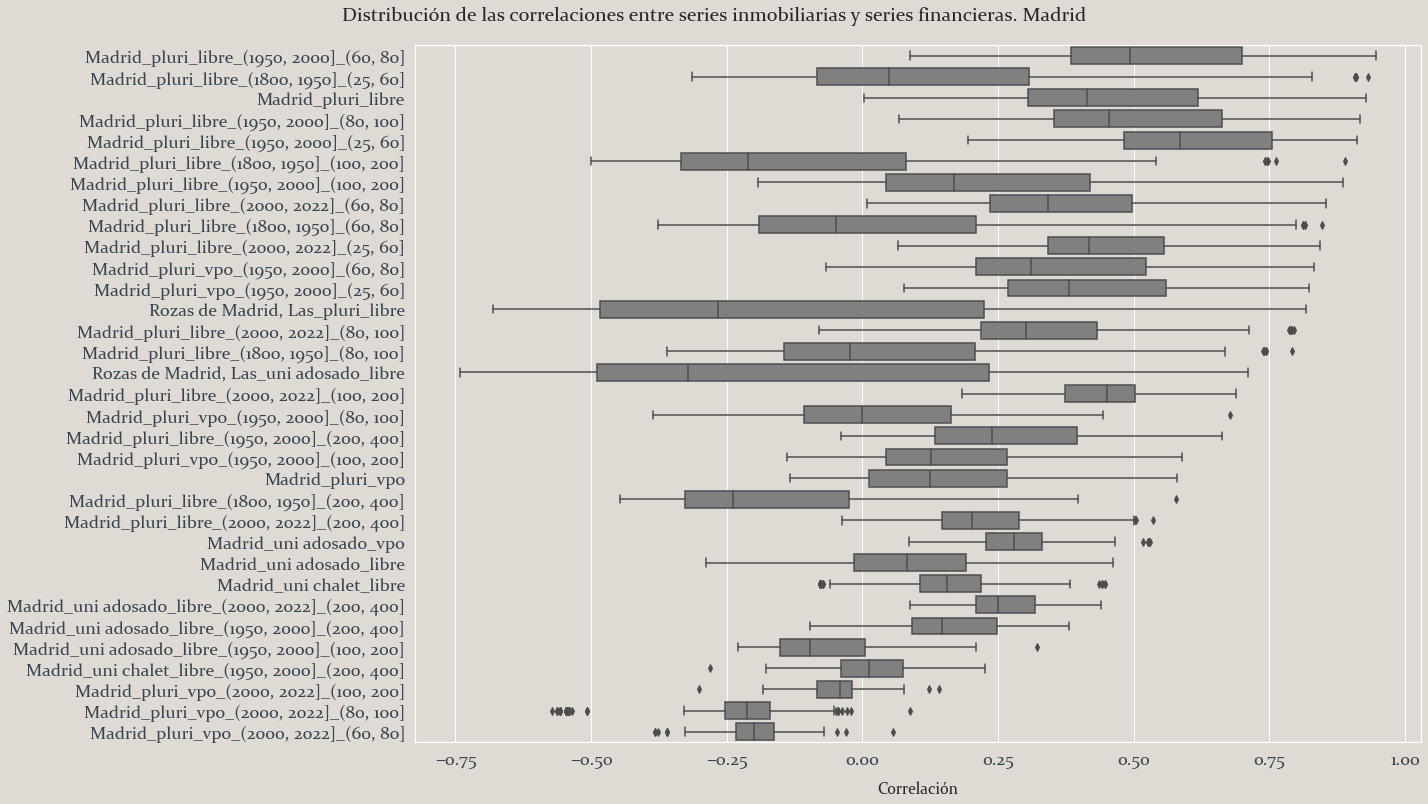

In [403]:
series_madrid = resultordered.loc[resultordered.architecture.str.contains('Madrid')]
ticks_style = font_manager.FontProperties(family='Constantia', size=18, weight='normal', stretch='normal')

fig, ax = plt.subplots(figsize = (16*1.25,9*1.25), facecolor=dp.rgb(dp.BEIGE))
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}

sns.boxplot(data=series_madrid, x="corr", y="architecture", ax=ax, color='grey')

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
plt.suptitle('Distribución de las correlaciones entre series inmobiliarias y series financieras. Madrid', **titlestyle)
plt.ylabel('')
plt.xlabel('Correlación', **labelstyle)
plt.tight_layout()
plt.savefig(f'EDA/plot/RealEstate/Correlaciones Madrid.png')
plt.show()
plt.close()

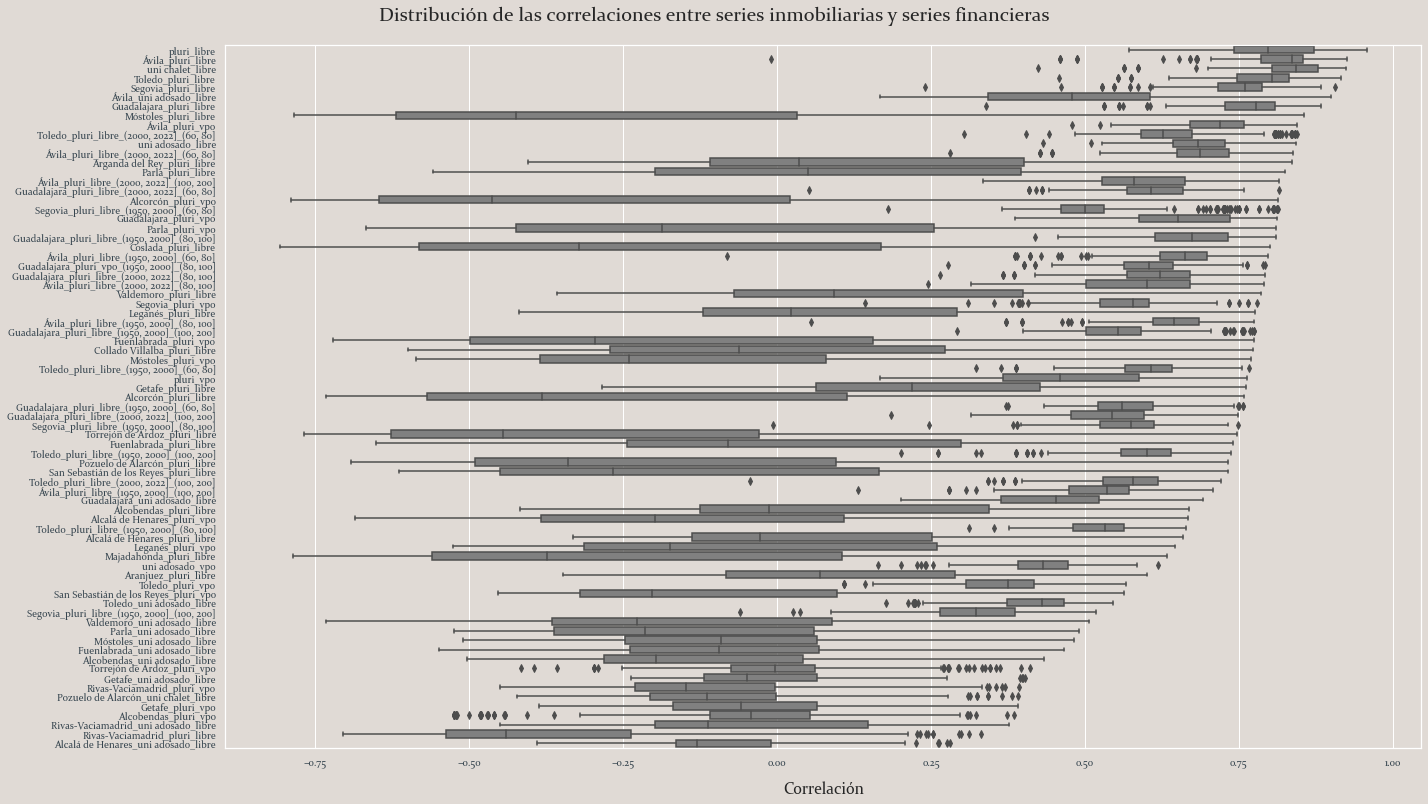

In [430]:
series_no_madrid = resultordered.loc[~resultordered.architecture.str.contains('Madrid')]
ticks_style = font_manager.FontProperties(family='Constantia', size=10, weight='normal', stretch='normal')

fig, ax = plt.subplots(figsize = (16*1.25,9*1.25), facecolor=dp.rgb(dp.BEIGE))
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}

sns.boxplot(data=series_no_madrid, x="corr", y="architecture", ax=ax, color='grey')

# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

plt.suptitle('Distribución de las correlaciones entre series inmobiliarias y series financieras', **titlestyle)
plt.ylabel('')
plt.xlabel('Correlación', **labelstyle)
plt.tight_layout()
plt.savefig(f'EDA/plot/RealEstate/Correlaciones.png')
plt.show()
plt.close()

In [411]:
resultordered

corr                              architecture      finance  \
0      0.958082                               pluri_libre   BE_21_23.3   
108    0.950914                               pluri_libre    BE_25_6.1   
216    0.948153                               pluri_libre   BE_8_32.12   
324    0.947113                               pluri_libre   BE_8_42.12   
432    0.945397  Madrid_pluri_libre_(1950, 2000]_(60, 80]     BE_4_A.4   
...         ...                                       ...          ...   
33257 -0.790130                        Alcorcón_pluri_vpo  BE_21_18.11   
33149 -0.790130                        Alcorcón_pluri_vpo   BE_21_18.8   
22133 -0.806789                       Coslada_pluri_libre    BE_4_14.8   
20729 -0.807791                       Coslada_pluri_libre    BE_4_13.8   
20621 -0.807791                       Coslada_pluri_libre   BE_8_19.10   

                                       SeriesDescription  
0      Emisiones de valores. Valores representativos ...  
108    Estadísticas generales. IPRI. Industrias manuf...  
216    EC y EFC. Balance según estados UEM. Pasivo. E...  
324    ED. Balance según estados UEM. Pasivo. Pasivos...  
432    EC y EFC. Balance agregado estados supervisión...  
...                                                  ...  
33257  Emisiones de valores. Valores representativos ...  
33149  Emisiones de valores. Valores representativos ...  
22133  ED. Créditos a OSR por finalidades. Otras fina...  
20729  EC y EFC. Créditos a OSR por finalidades. Otra...  
20621  EC y EFC. Créditos a OSR por finalidades. Otra...  

[35202 rows x 4 columns]

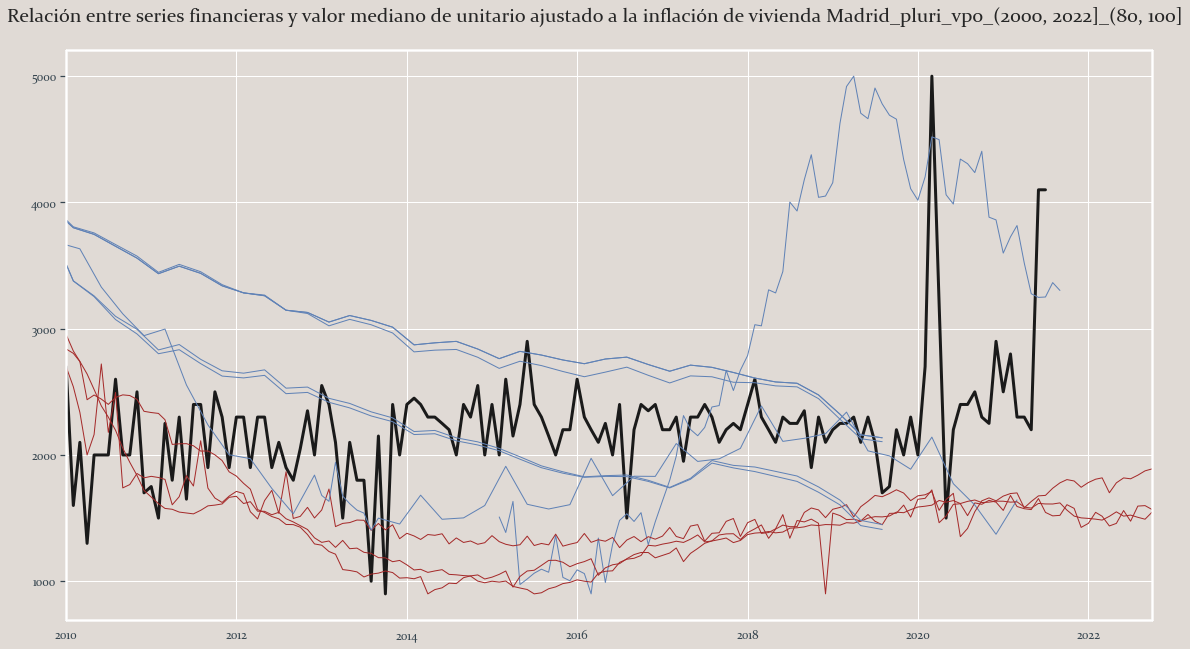

In [429]:
subplot_properties = {'figsize':(16,9), 'facecolor':dp.rgb(dp.BEIGE)}
titlestyle = {'size':20, 'fontname':'Constantia','ha':'center', 'va':'center'}

target = 'pluri_libre'
target = 'Madrid_pluri_vpo_(2000, 2022]_(80, 100]'

# features_graph = resultordered.loc[resultordered.architecture == target,'finance']
# LAs 10 series con mayor correlacion
features_graph = resultordered.loc[resultordered.architecture == target].sort_values(by='corr',ascending=False).head(10)['finance']
target_series = ds[target]
start = target_series.dropna().index[0]
ends = [target_series.dropna().index[-1]]

# pos_offset = []
fig, ax = plt.subplots(**subplot_properties)
p1, = ax.plot(target_series.axes[0], target_series, color='k', linewidth=3, label = f'{target}: Precio medio residencial Fotocasa')
for feature in features_graph:
    ax2 = ax.twinx()
    off = correlation[feature]['offset']
    feature_series = df[feature].shift(correlation[feature]['offset']).dropna()
    if off == 0:
        color = 'k'
    elif off > 0:
        color = dp.rgb(dp.RED)
        # pos_offset.append(feature)
        text = facts.loc[facts.SeriesAlias == feature,'SeriesDescription'].values[0]
        # text = text[:50]+'\n'+text[50:]
        # text = text[:100]
        # ax2.text(feature_series.axes[0][-1], feature_series[-1], text)
    else:
        color = dp.rgb(dp.GLAUCUS)
    ends.append(feature_series.dropna().index[-1])
    p2, = ax2.plot(feature_series.axes[0], feature_series, linewidth=1, color=color)
    ax2.set_yticks([])
# ax3 = ax.twinx()
# p1, = ax3.plot(target_series.axes[0], target_series, color='k', linewidth=3, label = f'{target}: Precio medio residencial Fotocasa')
end = max(ends)
plt.suptitle(f'Relación entre series financieras y valor mediano de unitario ajustado a la inflación de vivienda {target}', **titlestyle)
plt.ylabel('')
plt.xlabel('Año de construcción', **labelstyle)
plt.tight_layout()

ax.set_xlim([start, end])
# Change tick styles
ax.tick_params('x', colors=dp.rgb(dp.CHARCOAL))
ax.tick_params('y', colors=dp.rgb(dp.CHARCOAL))
for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

ax.grid(True)
plt.savefig(f'EDA/plot/RealEstate/Series positivas - {target}.png')
plt.show()
plt.close()

In [186]:
resultordered.loc[resultordered['corr']<-.7]

corr                   architecture     finance  \
13706 -0.700354  Torrejón de Ardoz_pluri_libre  BE_21_7.12   
6362  -0.705463  Rivas-Vaciamadrid_pluri_libre  BE_4_24.12   
5284  -0.705601          Fuenlabrada_pluri_vpo   BE_4_19.4   
5392  -0.705601          Fuenlabrada_pluri_vpo  BE_4_24.11   
12412 -0.706296             Alcorcón_pluri_vpo  BE_4_19.10   
6363  -0.706742    Valdemoro_uni adosado_libre  BE_4_24.12   
4852  -0.706847          Fuenlabrada_pluri_vpo   BE_4_18.4   
4960  -0.706847          Fuenlabrada_pluri_vpo   BE_4_12.5   
4744  -0.706847          Fuenlabrada_pluri_vpo  BE_4_23.12   
9605  -0.707055            Coslada_pluri_libre   BE_1_13.5   
12304 -0.707216             Alcorcón_pluri_vpo   BE_4_12.7   
12196 -0.707216             Alcorcón_pluri_vpo  BE_4_18.10   
5822  -0.710390             Alcorcón_pluri_vpo  BE_4_23.13   
14680 -0.713047           Móstoles_pluri_libre   BE_3_21.1   
3232  -0.713434        Majadahonda_pluri_libre   BE_4_14.1   
11330 -0.715961           Alcorcón_pluri_libre   BE_4_12.8   
11438 -0.715961           Alcorcón_pluri_libre   BE_4_13.3   
13707 -0.716338             Alcorcón_pluri_vpo  BE_21_7.12   
14788 -0.717429           Móstoles_pluri_libre   BE_6_12.3   
5823  -0.718524          Fuenlabrada_pluri_vpo  BE_4_23.13   
12953 -0.719063            Coslada_pluri_libre   BE_8_19.1   
4961  -0.720636           Móstoles_pluri_libre   BE_4_12.5   
4853  -0.720636           Móstoles_pluri_libre   BE_4_18.4   
4745  -0.720636           Móstoles_pluri_libre  BE_4_23.12   
5285  -0.721097           Móstoles_pluri_libre   BE_4_19.4   
5393  -0.721097           Móstoles_pluri_libre  BE_4_24.11   
11439 -0.721228          Fuenlabrada_pluri_vpo   BE_4_13.3   
11331 -0.721228          Fuenlabrada_pluri_vpo   BE_4_12.8   
5824  -0.721964        Majadahonda_pluri_libre  BE_4_23.13   
2693  -0.722632    Valdemoro_uni adosado_libre   BE_4_23.6   
13708 -0.722684           Móstoles_pluri_libre  BE_21_7.12   
3880  -0.727603        Majadahonda_pluri_libre   BE_4_12.1   
3988  -0.727603        Majadahonda_pluri_libre   BE_4_13.1   
5825  -0.728389           Móstoles_pluri_libre  BE_4_23.13   
6364  -0.731590  Torrejón de Ardoz_pluri_libre  BE_4_24.12   
3665  -0.732356    Valdemoro_uni adosado_libre   BE_4_24.6   
15112 -0.737556           Móstoles_pluri_libre   BE_8_18.1   
14681 -0.738802             Alcorcón_pluri_vpo   BE_3_21.1   
15113 -0.740223  Torrejón de Ardoz_pluri_libre   BE_8_18.1   
14789 -0.743703             Alcorcón_pluri_vpo   BE_6_12.3   
3233  -0.746137            Coslada_pluri_libre   BE_4_14.1   
3881  -0.756809            Coslada_pluri_libre   BE_4_12.1   
3989  -0.756809            Coslada_pluri_libre   BE_4_13.1   
5716  -0.757226            Coslada_pluri_libre   BE_4_14.3   
1721  -0.757456        Majadahonda_pluri_libre  BE_4_24.15   
11332 -0.760544            Coslada_pluri_libre   BE_4_12.8   
11440 -0.760544            Coslada_pluri_libre   BE_4_13.3   
13709 -0.770380            Coslada_pluri_libre  BE_21_7.12   
12845 -0.771130            Coslada_pluri_libre  BE_4_12.15   
5717  -0.773091        Majadahonda_pluri_libre   BE_4_14.3   
6365  -0.782064             Alcorcón_pluri_vpo  BE_4_24.12   
11441 -0.785995        Majadahonda_pluri_libre   BE_4_13.3   
11333 -0.785995        Majadahonda_pluri_libre   BE_4_12.8   
12413 -0.786484            Coslada_pluri_libre  BE_4_19.10   
12305 -0.788032            Coslada_pluri_libre   BE_4_12.7   
12197 -0.788032            Coslada_pluri_libre  BE_4_18.10   

                                       SeriesDescription  
13706  Emisiones de valores. Valores representativos ...  
6362   ED. Créditos a OSR por finalidades. Financiaci...  
5284   ED. Créditos a OSR por finalidades. Financiaci...  
5392   ED. Créditos a OSR por finalidades. Financiaci...  
12412  ED. Créditos a OSR por finalidades. Financiaci...  
6363   ED. Créditos a OSR por finalidades. Financiaci...  
4852   EC y EFC. Créditos a OSR por finalidades. Fina...  
4960